In [5]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 일별 데이터 집계
df['date'] = df['datetime'].dt.date
daily_df = df.groupby('date').agg({
    'opening_price': 'first',
    'closing_price': 'last',
    'high_price': 'max',
    'low_price': 'min',
    'trade_volume': 'sum',
    'year': 'first',
    'month': 'first',
    'day': 'first'
}).reset_index()

daily_df.sort_values(by='date', inplace=True)
daily_df.reset_index(drop=True, inplace=True)

# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5일 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5d_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10일 SMA 사용)
    df['10d_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10d_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10d_sma'] + 2 * df['10d_std']
    df['lower_band'] = df['10d_sma'] - 2 * df['10d_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10d_sma']

    # RSI 계산 (9일)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5일)
    df['low_5d'] = df['low_price'].rolling(window=5).min()
    df['high_5d'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5d']) / (df['high_5d'] - df['low_5d'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
daily_df = calculate_technical_indicators(daily_df)

# 입력 피처 선택 (논문 기반)
features = [
    'opening_price', 'closing_price', 'high_price', 'low_price', '5d_wma', 
    '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d', 'year', 'month', 'day'
]
target = 'closing_price' # 논문에서는 가격 변동을 예측하지만, 편의상 종가를 예측 목표로 설정

# 데이터 스케일링
scaler = MinMaxScaler()
daily_df[features] = scaler.fit_transform(daily_df[features])

# 타겟 변수 생성 (다음 날 종가)
daily_df['target'] = daily_df['closing_price'].shift(-1)
daily_df.dropna(inplace=True)

# 데이터 분할
train_ratio = 0.7
train_size = int(len(daily_df) * train_ratio)
train_df = daily_df[:train_size]
test_df = daily_df[train_size:]

# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.target) - self.sequence_length

    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length]
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

sequence_length = 1
train_dataset = BitcoinDataset(train_df, features, 'target', sequence_length)
test_dataset = BitcoinDataset(test_df, features, 'target', sequence_length)

# 데이터 로더 생성
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
         h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         return out

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
hidden_size = 100  # 논문 기반으로 적절한 값 설정
num_layers = 5  # DNN 레이어 수 (논문 기반)
model_type = 'DNN' # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')

if model_type == 'DNN':
  model = DNN(input_size, hidden_size, num_layers).to(device)
elif model_type == 'BasicRNN':
  model = BasicRNN(input_size, hidden_size).to(device)
elif model_type == 'LSTM-RNN':
  model = LSTM_RNN(input_size, hidden_size).to(device)
elif model_type == 'GRU-RNN':
  model = GRU_RNN(input_size, hidden_size).to(device)
elif model_type == 'BidirectionalRNN':
    model = BidirectionalRNN(input_size, hidden_size).to(device)
else:
  raise ValueError("Invalid Model type")
  

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100 # 논문 기반 에폭 수

def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type)
    # 모델 평가
    evaluate_model(trained_model, test_loader, criterion, model_type)

Using device: cuda


Epoch 1/100: 100%|██████████| 184/184 [00:00<00:00, 490.52it/s]


Epoch 1/100, Average Loss: 0.0059


Epoch 2/100: 100%|██████████| 184/184 [00:00<00:00, 806.85it/s]


Epoch 2/100, Average Loss: 0.0003


Epoch 3/100: 100%|██████████| 184/184 [00:00<00:00, 670.67it/s]


Epoch 3/100, Average Loss: 0.0003


Epoch 4/100: 100%|██████████| 184/184 [00:00<00:00, 703.35it/s]


Epoch 4/100, Average Loss: 0.0003


Epoch 5/100: 100%|██████████| 184/184 [00:00<00:00, 665.56it/s]


Epoch 5/100, Average Loss: 0.0002


Epoch 6/100: 100%|██████████| 184/184 [00:00<00:00, 754.17it/s]


Epoch 6/100, Average Loss: 0.0002


Epoch 7/100: 100%|██████████| 184/184 [00:00<00:00, 749.94it/s]


Epoch 7/100, Average Loss: 0.0003


Epoch 8/100: 100%|██████████| 184/184 [00:00<00:00, 727.12it/s]


Epoch 8/100, Average Loss: 0.0002


Epoch 9/100: 100%|██████████| 184/184 [00:00<00:00, 667.07it/s]


Epoch 9/100, Average Loss: 0.0002


Epoch 10/100: 100%|██████████| 184/184 [00:00<00:00, 439.80it/s]


Epoch 10/100, Average Loss: 0.0002


Epoch 11/100: 100%|██████████| 184/184 [00:00<00:00, 762.50it/s]


Epoch 11/100, Average Loss: 0.0002


Epoch 12/100: 100%|██████████| 184/184 [00:00<00:00, 575.04it/s]


Epoch 12/100, Average Loss: 0.0002


Epoch 13/100: 100%|██████████| 184/184 [00:00<00:00, 640.70it/s]


Epoch 13/100, Average Loss: 0.0003


Epoch 14/100: 100%|██████████| 184/184 [00:00<00:00, 688.41it/s]


Epoch 14/100, Average Loss: 0.0002


Epoch 15/100: 100%|██████████| 184/184 [00:00<00:00, 759.33it/s]


Epoch 15/100, Average Loss: 0.0002


Epoch 16/100: 100%|██████████| 184/184 [00:00<00:00, 771.38it/s]


Epoch 16/100, Average Loss: 0.0002


Epoch 17/100: 100%|██████████| 184/184 [00:00<00:00, 761.78it/s]


Epoch 17/100, Average Loss: 0.0002


Epoch 18/100: 100%|██████████| 184/184 [00:00<00:00, 719.88it/s]


Epoch 18/100, Average Loss: 0.0002


Epoch 19/100: 100%|██████████| 184/184 [00:00<00:00, 746.06it/s]


Epoch 19/100, Average Loss: 0.0002


Epoch 20/100: 100%|██████████| 184/184 [00:00<00:00, 668.03it/s]


Epoch 20/100, Average Loss: 0.0002


Epoch 21/100: 100%|██████████| 184/184 [00:00<00:00, 702.32it/s]


Epoch 21/100, Average Loss: 0.0002


Epoch 22/100: 100%|██████████| 184/184 [00:00<00:00, 744.29it/s]


Epoch 22/100, Average Loss: 0.0002


Epoch 23/100: 100%|██████████| 184/184 [00:00<00:00, 766.00it/s]


Epoch 23/100, Average Loss: 0.0002


Epoch 24/100: 100%|██████████| 184/184 [00:00<00:00, 426.40it/s]


Epoch 24/100, Average Loss: 0.0002


Epoch 25/100: 100%|██████████| 184/184 [00:00<00:00, 652.01it/s]


Epoch 25/100, Average Loss: 0.0003


Epoch 26/100: 100%|██████████| 184/184 [00:00<00:00, 672.13it/s]


Epoch 26/100, Average Loss: 0.0002


Epoch 27/100: 100%|██████████| 184/184 [00:00<00:00, 696.88it/s]


Epoch 27/100, Average Loss: 0.0003


Epoch 28/100: 100%|██████████| 184/184 [00:00<00:00, 667.04it/s]


Epoch 28/100, Average Loss: 0.0002


Epoch 29/100: 100%|██████████| 184/184 [00:00<00:00, 704.49it/s]


Epoch 29/100, Average Loss: 0.0001


Epoch 30/100: 100%|██████████| 184/184 [00:00<00:00, 612.73it/s]


Epoch 30/100, Average Loss: 0.0002


Epoch 31/100: 100%|██████████| 184/184 [00:00<00:00, 589.39it/s]


Epoch 31/100, Average Loss: 0.0002


Epoch 32/100: 100%|██████████| 184/184 [00:00<00:00, 632.54it/s]


Epoch 32/100, Average Loss: 0.0002


Epoch 33/100: 100%|██████████| 184/184 [00:00<00:00, 560.14it/s]


Epoch 33/100, Average Loss: 0.0002


Epoch 34/100: 100%|██████████| 184/184 [00:00<00:00, 588.88it/s]


Epoch 34/100, Average Loss: 0.0002


Epoch 35/100: 100%|██████████| 184/184 [00:00<00:00, 600.61it/s]


Epoch 35/100, Average Loss: 0.0002


Epoch 36/100: 100%|██████████| 184/184 [00:00<00:00, 618.55it/s]


Epoch 36/100, Average Loss: 0.0002


Epoch 37/100: 100%|██████████| 184/184 [00:00<00:00, 631.13it/s]


Epoch 37/100, Average Loss: 0.0002


Epoch 38/100: 100%|██████████| 184/184 [00:00<00:00, 586.86it/s]


Epoch 38/100, Average Loss: 0.0002


Epoch 39/100: 100%|██████████| 184/184 [00:00<00:00, 599.65it/s]


Epoch 39/100, Average Loss: 0.0002


Epoch 40/100: 100%|██████████| 184/184 [00:00<00:00, 570.71it/s]


Epoch 40/100, Average Loss: 0.0002


Epoch 41/100: 100%|██████████| 184/184 [00:00<00:00, 573.93it/s]


Epoch 41/100, Average Loss: 0.0002


Epoch 42/100: 100%|██████████| 184/184 [00:00<00:00, 578.27it/s]


Epoch 42/100, Average Loss: 0.0002


Epoch 43/100: 100%|██████████| 184/184 [00:00<00:00, 610.64it/s]


Epoch 43/100, Average Loss: 0.0002


Epoch 44/100: 100%|██████████| 184/184 [00:00<00:00, 598.51it/s]


Epoch 44/100, Average Loss: 0.0002


Epoch 45/100: 100%|██████████| 184/184 [00:00<00:00, 615.34it/s]


Epoch 45/100, Average Loss: 0.0002


Epoch 46/100: 100%|██████████| 184/184 [00:00<00:00, 622.78it/s]


Epoch 46/100, Average Loss: 0.0002


Epoch 47/100: 100%|██████████| 184/184 [00:00<00:00, 613.34it/s]


Epoch 47/100, Average Loss: 0.0002


Epoch 48/100: 100%|██████████| 184/184 [00:00<00:00, 616.40it/s]


Epoch 48/100, Average Loss: 0.0002


Epoch 49/100: 100%|██████████| 184/184 [00:00<00:00, 556.42it/s]


Epoch 49/100, Average Loss: 0.0002


Epoch 50/100: 100%|██████████| 184/184 [00:00<00:00, 612.71it/s]


Epoch 50/100, Average Loss: 0.0001


Epoch 51/100: 100%|██████████| 184/184 [00:00<00:00, 581.11it/s]


Epoch 51/100, Average Loss: 0.0001


Epoch 52/100: 100%|██████████| 184/184 [00:00<00:00, 573.57it/s]


Epoch 52/100, Average Loss: 0.0002


Epoch 53/100: 100%|██████████| 184/184 [00:00<00:00, 576.76it/s]


Epoch 53/100, Average Loss: 0.0001


Epoch 54/100: 100%|██████████| 184/184 [00:00<00:00, 588.62it/s]


Epoch 54/100, Average Loss: 0.0001


Epoch 55/100: 100%|██████████| 184/184 [00:00<00:00, 599.57it/s]


Epoch 55/100, Average Loss: 0.0001


Epoch 56/100: 100%|██████████| 184/184 [00:00<00:00, 639.83it/s]


Epoch 56/100, Average Loss: 0.0002


Epoch 57/100: 100%|██████████| 184/184 [00:00<00:00, 570.61it/s]


Epoch 57/100, Average Loss: 0.0001


Epoch 58/100: 100%|██████████| 184/184 [00:00<00:00, 621.02it/s]


Epoch 58/100, Average Loss: 0.0002


Epoch 59/100: 100%|██████████| 184/184 [00:00<00:00, 612.79it/s]


Epoch 59/100, Average Loss: 0.0001


Epoch 60/100: 100%|██████████| 184/184 [00:00<00:00, 537.48it/s]


Epoch 60/100, Average Loss: 0.0001


Epoch 61/100: 100%|██████████| 184/184 [00:00<00:00, 609.29it/s]


Epoch 61/100, Average Loss: 0.0002


Epoch 62/100: 100%|██████████| 184/184 [00:00<00:00, 520.13it/s]


Epoch 62/100, Average Loss: 0.0002


Epoch 63/100: 100%|██████████| 184/184 [00:00<00:00, 593.64it/s]


Epoch 63/100, Average Loss: 0.0001


Epoch 64/100: 100%|██████████| 184/184 [00:00<00:00, 591.15it/s]


Epoch 64/100, Average Loss: 0.0001


Epoch 65/100: 100%|██████████| 184/184 [00:00<00:00, 553.34it/s]


Epoch 65/100, Average Loss: 0.0001


Epoch 66/100: 100%|██████████| 184/184 [00:00<00:00, 597.37it/s]


Epoch 66/100, Average Loss: 0.0002


Epoch 67/100: 100%|██████████| 184/184 [00:00<00:00, 595.88it/s]


Epoch 67/100, Average Loss: 0.0001


Epoch 68/100: 100%|██████████| 184/184 [00:00<00:00, 610.71it/s]


Epoch 68/100, Average Loss: 0.0001


Epoch 69/100: 100%|██████████| 184/184 [00:00<00:00, 592.45it/s]


Epoch 69/100, Average Loss: 0.0001


Epoch 70/100: 100%|██████████| 184/184 [00:00<00:00, 605.47it/s]


Epoch 70/100, Average Loss: 0.0001


Epoch 71/100: 100%|██████████| 184/184 [00:00<00:00, 583.15it/s]


Epoch 71/100, Average Loss: 0.0001


Epoch 72/100: 100%|██████████| 184/184 [00:00<00:00, 577.97it/s]


Epoch 72/100, Average Loss: 0.0002


Epoch 73/100: 100%|██████████| 184/184 [00:00<00:00, 608.91it/s]


Epoch 73/100, Average Loss: 0.0002


Epoch 74/100: 100%|██████████| 184/184 [00:00<00:00, 578.05it/s]


Epoch 74/100, Average Loss: 0.0001


Epoch 75/100: 100%|██████████| 184/184 [00:00<00:00, 627.96it/s]


Epoch 75/100, Average Loss: 0.0001


Epoch 76/100: 100%|██████████| 184/184 [00:00<00:00, 600.26it/s]


Epoch 76/100, Average Loss: 0.0001


Epoch 77/100: 100%|██████████| 184/184 [00:00<00:00, 612.45it/s]


Epoch 77/100, Average Loss: 0.0002


Epoch 78/100: 100%|██████████| 184/184 [00:00<00:00, 581.60it/s]


Epoch 78/100, Average Loss: 0.0001


Epoch 79/100: 100%|██████████| 184/184 [00:00<00:00, 549.66it/s]


Epoch 79/100, Average Loss: 0.0001


Epoch 80/100: 100%|██████████| 184/184 [00:00<00:00, 571.63it/s]


Epoch 80/100, Average Loss: 0.0001


Epoch 81/100: 100%|██████████| 184/184 [00:00<00:00, 557.82it/s]


Epoch 81/100, Average Loss: 0.0001


Epoch 82/100: 100%|██████████| 184/184 [00:00<00:00, 584.98it/s]


Epoch 82/100, Average Loss: 0.0001


Epoch 83/100: 100%|██████████| 184/184 [00:00<00:00, 597.18it/s]


Epoch 83/100, Average Loss: 0.0001


Epoch 84/100: 100%|██████████| 184/184 [00:00<00:00, 612.98it/s]


Epoch 84/100, Average Loss: 0.0002


Epoch 85/100: 100%|██████████| 184/184 [00:00<00:00, 620.55it/s]


Epoch 85/100, Average Loss: 0.0001


Epoch 86/100: 100%|██████████| 184/184 [00:00<00:00, 547.44it/s]


Epoch 86/100, Average Loss: 0.0001


Epoch 87/100: 100%|██████████| 184/184 [00:00<00:00, 599.94it/s]


Epoch 87/100, Average Loss: 0.0002


Epoch 88/100: 100%|██████████| 184/184 [00:00<00:00, 605.24it/s]


Epoch 88/100, Average Loss: 0.0001


Epoch 89/100: 100%|██████████| 184/184 [00:00<00:00, 587.42it/s]


Epoch 89/100, Average Loss: 0.0001


Epoch 90/100: 100%|██████████| 184/184 [00:00<00:00, 591.36it/s]


Epoch 90/100, Average Loss: 0.0001


Epoch 91/100: 100%|██████████| 184/184 [00:00<00:00, 609.47it/s]


Epoch 91/100, Average Loss: 0.0001


Epoch 92/100: 100%|██████████| 184/184 [00:00<00:00, 562.87it/s]


Epoch 92/100, Average Loss: 0.0001


Epoch 93/100: 100%|██████████| 184/184 [00:00<00:00, 559.07it/s]


Epoch 93/100, Average Loss: 0.0001


Epoch 94/100: 100%|██████████| 184/184 [00:00<00:00, 628.09it/s]


Epoch 94/100, Average Loss: 0.0001


Epoch 95/100: 100%|██████████| 184/184 [00:00<00:00, 604.27it/s]


Epoch 95/100, Average Loss: 0.0001


Epoch 96/100: 100%|██████████| 184/184 [00:00<00:00, 597.15it/s]


Epoch 96/100, Average Loss: 0.0001


Epoch 97/100: 100%|██████████| 184/184 [00:00<00:00, 620.62it/s]


Epoch 97/100, Average Loss: 0.0001


Epoch 98/100: 100%|██████████| 184/184 [00:00<00:00, 612.69it/s]


Epoch 98/100, Average Loss: 0.0001


Epoch 99/100: 100%|██████████| 184/184 [00:00<00:00, 577.70it/s]


Epoch 99/100, Average Loss: 0.0001


Epoch 100/100: 100%|██████████| 184/184 [00:00<00:00, 583.56it/s]

Epoch 100/100, Average Loss: 0.0002
Test Loss: 0.0043


24년도예측

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\2373307464.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features] = scaler.fit_transform(train_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\2373307464.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[features] = scaler.transform(test_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\2373307464.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy

train_df length: 1600
test_df length: 687
validation_df length: 339
Using device: cuda


Epoch 1/100: 100%|██████████| 160/160 [00:00<00:00, 446.09it/s]


Epoch 1/100, Average Loss: 920699768248729.6250


Epoch 2/100: 100%|██████████| 160/160 [00:00<00:00, 765.74it/s]


Epoch 2/100, Average Loss: 385577214935040.0000


Epoch 3/100: 100%|██████████| 160/160 [00:00<00:00, 784.49it/s]


Epoch 3/100, Average Loss: 178193865637888.0000


Epoch 4/100: 100%|██████████| 160/160 [00:00<00:00, 820.57it/s]


Epoch 4/100, Average Loss: 74827497852108.7969


Epoch 5/100: 100%|██████████| 160/160 [00:00<00:00, 727.25it/s]


Epoch 5/100, Average Loss: 12751699554304.0000


Epoch 6/100: 100%|██████████| 160/160 [00:00<00:00, 802.60it/s]


Epoch 6/100, Average Loss: 4453770295910.4004


Epoch 7/100: 100%|██████████| 160/160 [00:00<00:00, 783.24it/s]


Epoch 7/100, Average Loss: 3735874610380.7998


Epoch 8/100: 100%|██████████| 160/160 [00:00<00:00, 806.55it/s]


Epoch 8/100, Average Loss: 3283555237273.6001


Epoch 9/100: 100%|██████████| 160/160 [00:00<00:00, 804.70it/s]


Epoch 9/100, Average Loss: 2933984915865.6001


Epoch 10/100: 100%|██████████| 160/160 [00:00<00:00, 662.52it/s]


Epoch 10/100, Average Loss: 2716437369446.3999


Epoch 11/100: 100%|██████████| 160/160 [00:00<00:00, 638.62it/s]


Epoch 11/100, Average Loss: 2511880075878.3999


Epoch 12/100: 100%|██████████| 160/160 [00:00<00:00, 696.37it/s]


Epoch 12/100, Average Loss: 2336327606681.6001


Epoch 13/100: 100%|██████████| 160/160 [00:00<00:00, 777.40it/s]


Epoch 13/100, Average Loss: 2230541214822.3999


Epoch 14/100: 100%|██████████| 160/160 [00:00<00:00, 660.44it/s]


Epoch 14/100, Average Loss: 2175866810163.2000


Epoch 15/100: 100%|██████████| 160/160 [00:00<00:00, 780.72it/s]


Epoch 15/100, Average Loss: 2015461519462.3999


Epoch 16/100: 100%|██████████| 160/160 [00:00<00:00, 790.23it/s]


Epoch 16/100, Average Loss: 1957088970137.6001


Epoch 17/100: 100%|██████████| 160/160 [00:00<00:00, 761.97it/s]


Epoch 17/100, Average Loss: 1916288510771.2000


Epoch 18/100: 100%|██████████| 160/160 [00:00<00:00, 772.17it/s]


Epoch 18/100, Average Loss: 1849123604172.8000


Epoch 19/100: 100%|██████████| 160/160 [00:00<00:00, 679.57it/s]


Epoch 19/100, Average Loss: 1824890445516.8000


Epoch 20/100: 100%|██████████| 160/160 [00:00<00:00, 796.48it/s]


Epoch 20/100, Average Loss: 1820063044915.2000


Epoch 21/100: 100%|██████████| 160/160 [00:00<00:00, 811.34it/s]


Epoch 21/100, Average Loss: 1781683319398.3999


Epoch 22/100: 100%|██████████| 160/160 [00:00<00:00, 846.97it/s]


Epoch 22/100, Average Loss: 1809661783859.2000


Epoch 23/100: 100%|██████████| 160/160 [00:00<00:00, 810.82it/s]


Epoch 23/100, Average Loss: 1770931089203.2000


Epoch 24/100: 100%|██████████| 160/160 [00:00<00:00, 796.01it/s]


Epoch 24/100, Average Loss: 1702544359577.6001


Epoch 25/100: 100%|██████████| 160/160 [00:00<00:00, 802.19it/s]


Epoch 25/100, Average Loss: 1708803840307.2000


Epoch 26/100: 100%|██████████| 160/160 [00:00<00:00, 786.42it/s]


Epoch 26/100, Average Loss: 1772572614297.6001


Epoch 27/100: 100%|██████████| 160/160 [00:00<00:00, 795.47it/s]


Epoch 27/100, Average Loss: 1647253294233.6001


Epoch 28/100: 100%|██████████| 160/160 [00:00<00:00, 785.00it/s]


Epoch 28/100, Average Loss: 1628020057292.8000


Epoch 29/100: 100%|██████████| 160/160 [00:00<00:00, 705.79it/s]


Epoch 29/100, Average Loss: 1633567189401.6001


Epoch 30/100: 100%|██████████| 160/160 [00:00<00:00, 792.68it/s]


Epoch 30/100, Average Loss: 1662947370854.3999


Epoch 31/100: 100%|██████████| 160/160 [00:00<00:00, 672.51it/s]


Epoch 31/100, Average Loss: 1706288234649.6001


Epoch 32/100: 100%|██████████| 160/160 [00:00<00:00, 632.81it/s]


Epoch 32/100, Average Loss: 1773579491430.3999


Epoch 33/100: 100%|██████████| 160/160 [00:00<00:00, 654.13it/s]


Epoch 33/100, Average Loss: 1671023026073.6001


Epoch 34/100: 100%|██████████| 160/160 [00:00<00:00, 672.17it/s]


Epoch 34/100, Average Loss: 1607666473420.8000


Epoch 35/100: 100%|██████████| 160/160 [00:00<00:00, 761.52it/s]


Epoch 35/100, Average Loss: 1590433107558.3999


Epoch 36/100: 100%|██████████| 160/160 [00:00<00:00, 781.53it/s]


Epoch 36/100, Average Loss: 1620368436633.6001


Epoch 37/100: 100%|██████████| 160/160 [00:00<00:00, 754.10it/s]


Epoch 37/100, Average Loss: 1657814250496.0000


Epoch 38/100: 100%|██████████| 160/160 [00:00<00:00, 755.35it/s]


Epoch 38/100, Average Loss: 1706237609011.2000


Epoch 39/100: 100%|██████████| 160/160 [00:00<00:00, 700.72it/s]


Epoch 39/100, Average Loss: 1653284763392.0000


Epoch 40/100: 100%|██████████| 160/160 [00:00<00:00, 620.30it/s]


Epoch 40/100, Average Loss: 1693121604915.2000


Epoch 41/100: 100%|██████████| 160/160 [00:00<00:00, 730.43it/s]


Epoch 41/100, Average Loss: 1563998500710.3999


Epoch 42/100: 100%|██████████| 160/160 [00:00<00:00, 725.73it/s]


Epoch 42/100, Average Loss: 1646112423859.2000


Epoch 43/100: 100%|██████████| 160/160 [00:00<00:00, 614.61it/s]


Epoch 43/100, Average Loss: 1605702835481.6001


Epoch 44/100: 100%|██████████| 160/160 [00:00<00:00, 630.11it/s]


Epoch 44/100, Average Loss: 1618006297497.6001


Epoch 45/100: 100%|██████████| 160/160 [00:00<00:00, 629.40it/s]


Epoch 45/100, Average Loss: 1592713790105.6001


Epoch 46/100: 100%|██████████| 160/160 [00:00<00:00, 605.95it/s]


Epoch 46/100, Average Loss: 1595383415961.6001


Epoch 47/100: 100%|██████████| 160/160 [00:00<00:00, 616.47it/s]


Epoch 47/100, Average Loss: 1607746533939.2000


Epoch 48/100: 100%|██████████| 160/160 [00:00<00:00, 636.39it/s]


Epoch 48/100, Average Loss: 1606325791078.3999


Epoch 49/100: 100%|██████████| 160/160 [00:00<00:00, 612.60it/s]


Epoch 49/100, Average Loss: 1587841304832.0000


Epoch 50/100: 100%|██████████| 160/160 [00:00<00:00, 592.14it/s]


Epoch 50/100, Average Loss: 1542198414182.3999


Epoch 51/100: 100%|██████████| 160/160 [00:00<00:00, 612.75it/s]


Epoch 51/100, Average Loss: 1678554936678.3999


Epoch 52/100: 100%|██████████| 160/160 [00:00<00:00, 623.35it/s]


Epoch 52/100, Average Loss: 1555263239091.2000


Epoch 53/100: 100%|██████████| 160/160 [00:00<00:00, 619.62it/s]


Epoch 53/100, Average Loss: 1560428996556.8000


Epoch 54/100: 100%|██████████| 160/160 [00:00<00:00, 619.86it/s]


Epoch 54/100, Average Loss: 1523995508812.8000


Epoch 55/100: 100%|██████████| 160/160 [00:00<00:00, 617.25it/s]


Epoch 55/100, Average Loss: 1526101201100.8000


Epoch 56/100: 100%|██████████| 160/160 [00:00<00:00, 612.46it/s]


Epoch 56/100, Average Loss: 1618763199385.6001


Epoch 57/100: 100%|██████████| 160/160 [00:00<00:00, 594.80it/s]


Epoch 57/100, Average Loss: 1586324561612.8000


Epoch 58/100: 100%|██████████| 160/160 [00:00<00:00, 534.19it/s]


Epoch 58/100, Average Loss: 1601132424755.2000


Epoch 59/100: 100%|██████████| 160/160 [00:00<00:00, 615.02it/s]


Epoch 59/100, Average Loss: 1553180733184.0000


Epoch 60/100: 100%|██████████| 160/160 [00:00<00:00, 616.99it/s]


Epoch 60/100, Average Loss: 1559743491072.0000


Epoch 61/100: 100%|██████████| 160/160 [00:00<00:00, 608.27it/s]


Epoch 61/100, Average Loss: 1642013861273.6001


Epoch 62/100: 100%|██████████| 160/160 [00:00<00:00, 614.16it/s]


Epoch 62/100, Average Loss: 1570067008204.8000


Epoch 63/100: 100%|██████████| 160/160 [00:00<00:00, 627.86it/s]


Epoch 63/100, Average Loss: 1580944508211.2000


Epoch 64/100: 100%|██████████| 160/160 [00:00<00:00, 645.19it/s]


Epoch 64/100, Average Loss: 1551965650227.2000


Epoch 65/100: 100%|██████████| 160/160 [00:00<00:00, 632.45it/s]


Epoch 65/100, Average Loss: 1562697290700.8000


Epoch 66/100: 100%|██████████| 160/160 [00:00<00:00, 587.64it/s]


Epoch 66/100, Average Loss: 1511865934233.6001


Epoch 67/100: 100%|██████████| 160/160 [00:00<00:00, 647.53it/s]


Epoch 67/100, Average Loss: 1539019100825.6001


Epoch 68/100: 100%|██████████| 160/160 [00:00<00:00, 645.47it/s]


Epoch 68/100, Average Loss: 1570442898739.2000


Epoch 69/100: 100%|██████████| 160/160 [00:00<00:00, 676.62it/s]


Epoch 69/100, Average Loss: 1561579721395.2000


Epoch 70/100: 100%|██████████| 160/160 [00:00<00:00, 668.13it/s]


Epoch 70/100, Average Loss: 1540040556032.0000


Epoch 71/100: 100%|██████████| 160/160 [00:00<00:00, 672.72it/s]


Epoch 71/100, Average Loss: 1577096043955.2000


Epoch 72/100: 100%|██████████| 160/160 [00:00<00:00, 681.62it/s]


Epoch 72/100, Average Loss: 1538073917644.8000


Epoch 73/100: 100%|██████████| 160/160 [00:00<00:00, 645.67it/s]


Epoch 73/100, Average Loss: 1530186253772.8000


Epoch 74/100: 100%|██████████| 160/160 [00:00<00:00, 688.79it/s]


Epoch 74/100, Average Loss: 1619178719692.8000


Epoch 75/100: 100%|██████████| 160/160 [00:00<00:00, 668.21it/s]


Epoch 75/100, Average Loss: 1545673761433.6001


Epoch 76/100: 100%|██████████| 160/160 [00:00<00:00, 597.51it/s]


Epoch 76/100, Average Loss: 1557143595033.6001


Epoch 77/100: 100%|██████████| 160/160 [00:00<00:00, 682.76it/s]


Epoch 77/100, Average Loss: 1571566523392.0000


Epoch 78/100: 100%|██████████| 160/160 [00:00<00:00, 691.42it/s]


Epoch 78/100, Average Loss: 1664086320512.0000


Epoch 79/100: 100%|██████████| 160/160 [00:00<00:00, 657.23it/s]


Epoch 79/100, Average Loss: 1545283323980.8000


Epoch 80/100: 100%|██████████| 160/160 [00:00<00:00, 663.76it/s]


Epoch 80/100, Average Loss: 1574001138534.3999


Epoch 81/100: 100%|██████████| 160/160 [00:00<00:00, 664.35it/s]


Epoch 81/100, Average Loss: 1599349030195.2000


Epoch 82/100: 100%|██████████| 160/160 [00:00<00:00, 690.33it/s]


Epoch 82/100, Average Loss: 1612200043212.8000


Epoch 83/100: 100%|██████████| 160/160 [00:00<00:00, 678.24it/s]


Epoch 83/100, Average Loss: 1536982068710.3999


Epoch 84/100: 100%|██████████| 160/160 [00:00<00:00, 654.13it/s]


Epoch 84/100, Average Loss: 1587062255360.0000


Epoch 85/100: 100%|██████████| 160/160 [00:00<00:00, 682.60it/s]


Epoch 85/100, Average Loss: 1593008489088.0000


Epoch 86/100: 100%|██████████| 160/160 [00:00<00:00, 606.75it/s]


Epoch 86/100, Average Loss: 1501201088460.8000


Epoch 87/100: 100%|██████████| 160/160 [00:00<00:00, 641.26it/s]


Epoch 87/100, Average Loss: 1608292381388.8000


Epoch 88/100: 100%|██████████| 160/160 [00:00<00:00, 688.03it/s]


Epoch 88/100, Average Loss: 1511549928089.6001


Epoch 89/100: 100%|██████████| 160/160 [00:00<00:00, 680.70it/s]


Epoch 89/100, Average Loss: 1473494070937.6001


Epoch 90/100: 100%|██████████| 160/160 [00:00<00:00, 678.87it/s]


Epoch 90/100, Average Loss: 1482282634342.3999


Epoch 91/100: 100%|██████████| 160/160 [00:00<00:00, 627.48it/s]


Epoch 91/100, Average Loss: 1568474954777.6001


Epoch 92/100: 100%|██████████| 160/160 [00:00<00:00, 626.83it/s]


Epoch 92/100, Average Loss: 1566222509158.3999


Epoch 93/100: 100%|██████████| 160/160 [00:00<00:00, 625.91it/s]


Epoch 93/100, Average Loss: 1556265571737.6001


Epoch 94/100: 100%|██████████| 160/160 [00:00<00:00, 612.74it/s]


Epoch 94/100, Average Loss: 1601414993612.8000


Epoch 95/100: 100%|██████████| 160/160 [00:00<00:00, 649.27it/s]


Epoch 95/100, Average Loss: 1619394873344.0000


Epoch 96/100: 100%|██████████| 160/160 [00:00<00:00, 569.69it/s]


Epoch 96/100, Average Loss: 1578333903027.2000


Epoch 97/100: 100%|██████████| 160/160 [00:00<00:00, 623.69it/s]


Epoch 97/100, Average Loss: 1513547238732.8000


Epoch 98/100: 100%|██████████| 160/160 [00:00<00:00, 621.44it/s]


Epoch 98/100, Average Loss: 1483842871500.8000


Epoch 99/100: 100%|██████████| 160/160 [00:00<00:00, 645.74it/s]


Epoch 99/100, Average Loss: 1532287565760.0000


Epoch 100/100: 100%|██████████| 160/160 [00:00<00:00, 628.14it/s]


Epoch 100/100, Average Loss: 1522127974323.2000
Test Loss: 1173521476979.0144


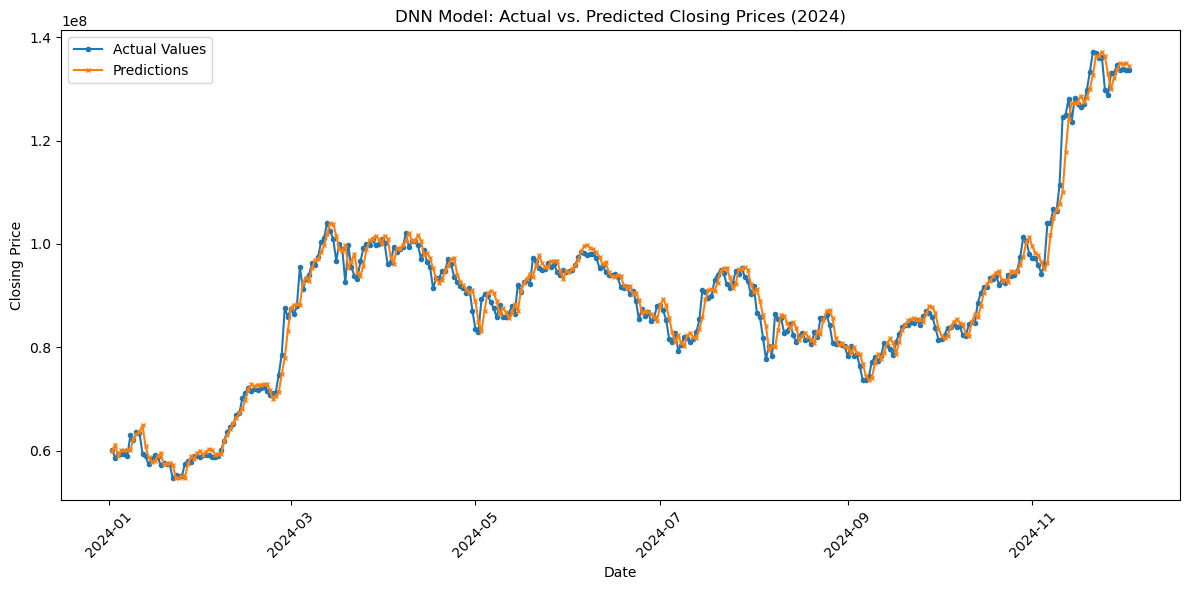

Plot saved to ./output/DNN\DNN_plot_20241230_112223.png
Model saved to ./output/DNN\DNN_model_20241230_112224.pth


In [8]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 일별 데이터 집계
df['date'] = df['datetime'].dt.date
daily_df = df.groupby('date').agg({
    'opening_price': 'first',
    'closing_price': 'last',
    'high_price': 'max',
    'low_price': 'min',
    'trade_volume': 'sum',
    'year': 'first',
    'month': 'first',
    'day': 'first'
}).reset_index()

daily_df.sort_values(by='date', inplace=True)
daily_df.reset_index(drop=True, inplace=True)

# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5일 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5d_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10일 SMA 사용)
    df['10d_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10d_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10d_sma'] + 2 * df['10d_std']
    df['lower_band'] = df['10d_sma'] - 2 * df['10d_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10d_sma']

    # RSI 계산 (9일)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5일)
    df['low_5d'] = df['low_price'].rolling(window=5).min()
    df['high_5d'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5d']) / (df['high_5d'] - df['low_5d'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
daily_df = calculate_technical_indicators(daily_df)

# 데이터 분할
validation_year = 2024
train_test_df = daily_df[daily_df['year'] < validation_year]
validation_df = daily_df[daily_df['year'] == validation_year]

train_ratio = 0.7
train_size = int(len(train_test_df) * train_ratio)
train_df = train_test_df[:train_size]
test_df = train_test_df[train_size:]


# 데이터 분할 확인
print(f"train_df length: {len(train_df)}")
print(f"test_df length: {len(test_df)}")
print(f"validation_df length: {len(validation_df)}")

# 입력 피처 선택 (논문 기반)
features = [
    'opening_price',  'high_price', 'low_price', '5d_wma', 
    '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d', 'year', 'month', 'day'
]
target = 'next_day_closing_price'  # 다음 날 종가 예측을 위해 변경

# 데이터 스케일링
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
validation_df[features] = scaler.transform(validation_df[features])

# 타겟 변수 생성 (다음 날 종가)
train_df['next_day_closing_price'] = train_df['closing_price'].shift(-1)
test_df['next_day_closing_price'] = test_df['closing_price'].shift(-1)
validation_df['next_day_closing_price'] = validation_df['closing_price'].shift(-1)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
validation_df.dropna(inplace=True)


# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
       return len(self.target) - self.sequence_length if len(self.target) > self.sequence_length else 0
    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length -1] # sequence_length 가 1이므로 idx + 0을 참조
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

sequence_length = 1
train_dataset = BitcoinDataset(train_df, features, 'next_day_closing_price', sequence_length)
test_dataset = BitcoinDataset(test_df, features, 'next_day_closing_price', sequence_length)
validation_dataset = BitcoinDataset(validation_df, features, 'next_day_closing_price', sequence_length)

# 데이터 로더 생성
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
         h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         return out

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
hidden_size = 100  # 논문 기반으로 적절한 값 설정
num_layers = 5  # DNN 레이어 수 (논문 기반)
model_type = 'DNN' # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')

if model_type == 'DNN':
  model = DNN(input_size, hidden_size, num_layers).to(device)
elif model_type == 'BasicRNN':
  model = BasicRNN(input_size, hidden_size).to(device)
elif model_type == 'LSTM-RNN':
  model = LSTM_RNN(input_size, hidden_size).to(device)
elif model_type == 'GRU-RNN':
  model = GRU_RNN(input_size, hidden_size).to(device)
elif model_type == 'BidirectionalRNN':
    model = BidirectionalRNN(input_size, hidden_size).to(device)
else:
  raise ValueError("Invalid Model type")
  

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100 # 논문 기반 에폭 수

def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

def validate_model(model, validation_loader, model_type):
    model.eval()
    predictions = []
    actual_values = []
    with torch.no_grad():
        for seq_x, seq_y in validation_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(seq_y.cpu().numpy())

    return predictions, actual_values

def plot_predictions(actual_values, predictions, validation_df, model_type):
    # 시각화
    dates = validation_df['date'].values[1:]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_values, label='Actual Values', marker='o', linestyle='-', markersize=3)
    plt.plot(dates, predictions, label='Predictions', marker='x', linestyle='-', markersize=3)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'{model_type} Model: Actual vs. Predicted Closing Prices (2024)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # 이미지 저장 경로 설정
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_plot_{timestamp}.png')

    plt.savefig(output_path)
    plt.show()
    print(f"Plot saved to {output_path}")

    
if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type)
    # 모델 평가
    evaluate_model(trained_model, test_loader, criterion, model_type)
    # 모델 검증
    predictions, actual_values = validate_model(trained_model, validation_loader, model_type)
    # 예측 시각화
    plot_predictions(actual_values, predictions, validation_df, model_type)

    # 모델 저장
    model_save_path = os.path.join(f'./output/{model_type}', f'{model_type}_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

23, 24 예측

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\73121893.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features] = scaler.fit_transform(train_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\73121893.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[features] = scaler.transform(test_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\73121893.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

train_df length: 1345
test_df length: 577
validation_df length: 704
Using device: cuda


Epoch 1/100: 100%|██████████| 135/135 [00:00<00:00, 415.19it/s]


Epoch 1/100, Average Loss: 490511439151468.0625


Epoch 2/100: 100%|██████████| 135/135 [00:00<00:00, 803.18it/s]


Epoch 2/100, Average Loss: 268350504873589.5625


Epoch 3/100: 100%|██████████| 135/135 [00:00<00:00, 729.14it/s]


Epoch 3/100, Average Loss: 159812593096142.6875


Epoch 4/100: 100%|██████████| 135/135 [00:00<00:00, 748.71it/s]


Epoch 4/100, Average Loss: 122889463010038.5156


Epoch 5/100: 100%|██████████| 135/135 [00:00<00:00, 767.92it/s]


Epoch 5/100, Average Loss: 80259466129620.3906


Epoch 6/100: 100%|██████████| 135/135 [00:00<00:00, 741.18it/s]


Epoch 6/100, Average Loss: 34948564912021.8086


Epoch 7/100: 100%|██████████| 135/135 [00:00<00:00, 787.35it/s]


Epoch 7/100, Average Loss: 11487302800725.3340


Epoch 8/100: 100%|██████████| 135/135 [00:00<00:00, 702.61it/s]


Epoch 8/100, Average Loss: 6741231091105.1855


Epoch 9/100: 100%|██████████| 135/135 [00:00<00:00, 759.11it/s]


Epoch 9/100, Average Loss: 5291263890894.6963


Epoch 10/100: 100%|██████████| 135/135 [00:00<00:00, 775.70it/s]


Epoch 10/100, Average Loss: 4377441614051.5557


Epoch 11/100: 100%|██████████| 135/135 [00:00<00:00, 614.38it/s]


Epoch 11/100, Average Loss: 3881779565545.2446


Epoch 12/100: 100%|██████████| 135/135 [00:00<00:00, 717.37it/s]


Epoch 12/100, Average Loss: 3466785928472.6519


Epoch 13/100: 100%|██████████| 135/135 [00:00<00:00, 726.65it/s]


Epoch 13/100, Average Loss: 3244581387438.4595


Epoch 14/100: 100%|██████████| 135/135 [00:00<00:00, 724.91it/s]


Epoch 14/100, Average Loss: 3098288974628.0298


Epoch 15/100: 100%|██████████| 135/135 [00:00<00:00, 723.78it/s]


Epoch 15/100, Average Loss: 2938329409369.1260


Epoch 16/100: 100%|██████████| 135/135 [00:00<00:00, 722.50it/s]


Epoch 16/100, Average Loss: 2802432120513.4224


Epoch 17/100: 100%|██████████| 135/135 [00:00<00:00, 743.57it/s]


Epoch 17/100, Average Loss: 2729599041111.2295


Epoch 18/100: 100%|██████████| 135/135 [00:00<00:00, 723.06it/s]


Epoch 18/100, Average Loss: 2802196026830.6963


Epoch 19/100: 100%|██████████| 135/135 [00:00<00:00, 672.29it/s]


Epoch 19/100, Average Loss: 2659292300356.2666


Epoch 20/100: 100%|██████████| 135/135 [00:00<00:00, 716.54it/s]


Epoch 20/100, Average Loss: 2555964603081.0073


Epoch 21/100: 100%|██████████| 135/135 [00:00<00:00, 712.98it/s]


Epoch 21/100, Average Loss: 2489775565604.0298


Epoch 22/100: 100%|██████████| 135/135 [00:00<00:00, 564.27it/s]


Epoch 22/100, Average Loss: 2463308001006.9331


Epoch 23/100: 100%|██████████| 135/135 [00:00<00:00, 588.31it/s]


Epoch 23/100, Average Loss: 2394451535462.3999


Epoch 24/100: 100%|██████████| 135/135 [00:00<00:00, 666.44it/s]


Epoch 24/100, Average Loss: 2549847906470.8740


Epoch 25/100: 100%|██████████| 135/135 [00:00<00:00, 708.04it/s]


Epoch 25/100, Average Loss: 2453451847118.6963


Epoch 26/100: 100%|██████████| 135/135 [00:00<00:00, 743.58it/s]


Epoch 26/100, Average Loss: 2417232395195.7334


Epoch 27/100: 100%|██████████| 135/135 [00:00<00:00, 722.13it/s]


Epoch 27/100, Average Loss: 2345409629631.5259


Epoch 28/100: 100%|██████████| 135/135 [00:00<00:00, 746.33it/s]


Epoch 28/100, Average Loss: 2403027827643.7334


Epoch 29/100: 100%|██████████| 135/135 [00:00<00:00, 657.54it/s]


Epoch 29/100, Average Loss: 2437967645293.9854


Epoch 30/100: 100%|██████████| 135/135 [00:00<00:00, 742.23it/s]


Epoch 30/100, Average Loss: 2367379090212.0298


Epoch 31/100: 100%|██████████| 135/135 [00:00<00:00, 709.84it/s]


Epoch 31/100, Average Loss: 2329657972963.5557


Epoch 32/100: 100%|██████████| 135/135 [00:00<00:00, 745.26it/s]


Epoch 32/100, Average Loss: 2374585567004.4443


Epoch 33/100: 100%|██████████| 135/135 [00:00<00:00, 683.34it/s]


Epoch 33/100, Average Loss: 2307067085816.4150


Epoch 34/100: 100%|██████████| 135/135 [00:00<00:00, 617.34it/s]


Epoch 34/100, Average Loss: 2273796968356.9775


Epoch 35/100: 100%|██████████| 135/135 [00:00<00:00, 589.96it/s]


Epoch 35/100, Average Loss: 2314661929991.5850


Epoch 36/100: 100%|██████████| 135/135 [00:00<00:00, 588.33it/s]


Epoch 36/100, Average Loss: 2307671002074.0742


Epoch 37/100: 100%|██████████| 135/135 [00:00<00:00, 599.47it/s]


Epoch 37/100, Average Loss: 2343167582086.6372


Epoch 38/100: 100%|██████████| 135/135 [00:00<00:00, 655.48it/s]


Epoch 38/100, Average Loss: 2431923218811.2593


Epoch 39/100: 100%|██████████| 135/135 [00:00<00:00, 622.59it/s]


Epoch 39/100, Average Loss: 2269152461710.2222


Epoch 40/100: 100%|██████████| 135/135 [00:00<00:00, 615.18it/s]


Epoch 40/100, Average Loss: 2349580830492.4443


Epoch 41/100: 100%|██████████| 135/135 [00:00<00:00, 592.72it/s]


Epoch 41/100, Average Loss: 2299758690607.4072


Epoch 42/100: 100%|██████████| 135/135 [00:00<00:00, 753.37it/s]


Epoch 42/100, Average Loss: 2234323704703.0518


Epoch 43/100: 100%|██████████| 135/135 [00:00<00:00, 750.13it/s]


Epoch 43/100, Average Loss: 2292723946109.1558


Epoch 44/100: 100%|██████████| 135/135 [00:00<00:00, 761.97it/s]


Epoch 44/100, Average Loss: 2225111751308.3257


Epoch 45/100: 100%|██████████| 135/135 [00:00<00:00, 757.59it/s]


Epoch 45/100, Average Loss: 2253996143866.3110


Epoch 46/100: 100%|██████████| 135/135 [00:00<00:00, 750.12it/s]


Epoch 46/100, Average Loss: 2322325289187.5557


Epoch 47/100: 100%|██████████| 135/135 [00:00<00:00, 757.39it/s]


Epoch 47/100, Average Loss: 2223124735893.8076


Epoch 48/100: 100%|██████████| 135/135 [00:00<00:00, 772.84it/s]


Epoch 48/100, Average Loss: 2313228694626.6074


Epoch 49/100: 100%|██████████| 135/135 [00:00<00:00, 705.26it/s]


Epoch 49/100, Average Loss: 2305975740249.1260


Epoch 50/100: 100%|██████████| 135/135 [00:00<00:00, 762.64it/s]


Epoch 50/100, Average Loss: 2231874477291.1406


Epoch 51/100: 100%|██████████| 135/135 [00:00<00:00, 719.10it/s]


Epoch 51/100, Average Loss: 2137185630678.2815


Epoch 52/100: 100%|██████████| 135/135 [00:00<00:00, 619.30it/s]


Epoch 52/100, Average Loss: 2252665856667.4961


Epoch 53/100: 100%|██████████| 135/135 [00:00<00:00, 625.20it/s]


Epoch 53/100, Average Loss: 2297191500762.0742


Epoch 54/100: 100%|██████████| 135/135 [00:00<00:00, 638.12it/s]


Epoch 54/100, Average Loss: 2293325484669.1558


Epoch 55/100: 100%|██████████| 135/135 [00:00<00:00, 617.45it/s]


Epoch 55/100, Average Loss: 2342325399521.6592


Epoch 56/100: 100%|██████████| 135/135 [00:00<00:00, 616.75it/s]


Epoch 56/100, Average Loss: 2289470276979.6743


Epoch 57/100: 100%|██████████| 135/135 [00:00<00:00, 694.55it/s]


Epoch 57/100, Average Loss: 2239604927268.0298


Epoch 58/100: 100%|██████████| 135/135 [00:00<00:00, 770.13it/s]


Epoch 58/100, Average Loss: 2204955423053.7480


Epoch 59/100: 100%|██████████| 135/135 [00:00<00:00, 710.08it/s]


Epoch 59/100, Average Loss: 2224804914911.7632


Epoch 60/100: 100%|██████████| 135/135 [00:00<00:00, 765.06it/s]


Epoch 60/100, Average Loss: 2177658520401.5408


Epoch 61/100: 100%|██████████| 135/135 [00:00<00:00, 761.97it/s]


Epoch 61/100, Average Loss: 2152452805093.4519


Epoch 62/100: 100%|██████████| 135/135 [00:00<00:00, 769.24it/s]


Epoch 62/100, Average Loss: 2174293389524.3853


Epoch 63/100: 100%|██████████| 135/135 [00:00<00:00, 769.92it/s]


Epoch 63/100, Average Loss: 2164305571202.8445


Epoch 64/100: 100%|██████████| 135/135 [00:00<00:00, 771.50it/s]


Epoch 64/100, Average Loss: 2150035343041.4221


Epoch 65/100: 100%|██████████| 135/135 [00:00<00:00, 765.33it/s]


Epoch 65/100, Average Loss: 2268229199492.7407


Epoch 66/100: 100%|██████████| 135/135 [00:00<00:00, 764.40it/s]


Epoch 66/100, Average Loss: 2175063633707.6147


Epoch 67/100: 100%|██████████| 135/135 [00:00<00:00, 685.29it/s]


Epoch 67/100, Average Loss: 2275838233167.6445


Epoch 68/100: 100%|██████████| 135/135 [00:00<00:00, 590.44it/s]


Epoch 68/100, Average Loss: 2268522512323.3184


Epoch 69/100: 100%|██████████| 135/135 [00:00<00:00, 591.11it/s]


Epoch 69/100, Average Loss: 2310972070115.5557


Epoch 70/100: 100%|██████████| 135/135 [00:00<00:00, 628.44it/s]


Epoch 70/100, Average Loss: 2219145733613.0371


Epoch 71/100: 100%|██████████| 135/135 [00:00<00:00, 629.47it/s]


Epoch 71/100, Average Loss: 2247721367718.8740


Epoch 72/100: 100%|██████████| 135/135 [00:00<00:00, 614.82it/s]


Epoch 72/100, Average Loss: 2148040365458.0149


Epoch 73/100: 100%|██████████| 135/135 [00:00<00:00, 577.08it/s]


Epoch 73/100, Average Loss: 2138120265576.2964


Epoch 74/100: 100%|██████████| 135/135 [00:00<00:00, 652.34it/s]


Epoch 74/100, Average Loss: 2284915085949.1558


Epoch 75/100: 100%|██████████| 135/135 [00:00<00:00, 741.23it/s]


Epoch 75/100, Average Loss: 2187449284350.1038


Epoch 76/100: 100%|██████████| 135/135 [00:00<00:00, 741.10it/s]


Epoch 76/100, Average Loss: 2089468122210.6074


Epoch 77/100: 100%|██████████| 135/135 [00:00<00:00, 746.78it/s]


Epoch 77/100, Average Loss: 2302445363624.7705


Epoch 78/100: 100%|██████████| 135/135 [00:00<00:00, 748.92it/s]


Epoch 78/100, Average Loss: 2122919868158.1038


Epoch 79/100: 100%|██████████| 135/135 [00:00<00:00, 705.68it/s]


Epoch 79/100, Average Loss: 2116317545843.6741


Epoch 80/100: 100%|██████████| 135/135 [00:00<00:00, 738.71it/s]


Epoch 80/100, Average Loss: 2140968020347.2593


Epoch 81/100: 100%|██████████| 135/135 [00:00<00:00, 738.81it/s]


Epoch 81/100, Average Loss: 2141686008065.8962


Epoch 82/100: 100%|██████████| 135/135 [00:00<00:00, 731.91it/s]


Epoch 82/100, Average Loss: 2100415827876.9778


Epoch 83/100: 100%|██████████| 135/135 [00:00<00:00, 722.76it/s]


Epoch 83/100, Average Loss: 2164615566313.2444


Epoch 84/100: 100%|██████████| 135/135 [00:00<00:00, 608.32it/s]


Epoch 84/100, Average Loss: 2127488062501.9260


Epoch 85/100: 100%|██████████| 135/135 [00:00<00:00, 581.38it/s]


Epoch 85/100, Average Loss: 2139640836065.6592


Epoch 86/100: 100%|██████████| 135/135 [00:00<00:00, 621.92it/s]


Epoch 86/100, Average Loss: 2170763211904.9482


Epoch 87/100: 100%|██████████| 135/135 [00:00<00:00, 618.25it/s]


Epoch 87/100, Average Loss: 2082713597724.4443


Epoch 88/100: 100%|██████████| 135/135 [00:00<00:00, 624.30it/s]


Epoch 88/100, Average Loss: 2153530648803.5557


Epoch 89/100: 100%|██████████| 135/135 [00:00<00:00, 614.67it/s]


Epoch 89/100, Average Loss: 2192574375769.1260


Epoch 90/100: 100%|██████████| 135/135 [00:00<00:00, 607.62it/s]


Epoch 90/100, Average Loss: 2169019961738.4297


Epoch 91/100: 100%|██████████| 135/135 [00:00<00:00, 576.72it/s]


Epoch 91/100, Average Loss: 2268545839164.6816


Epoch 92/100: 100%|██████████| 135/135 [00:00<00:00, 614.35it/s]


Epoch 92/100, Average Loss: 2245560228917.0962


Epoch 93/100: 100%|██████████| 135/135 [00:00<00:00, 622.29it/s]


Epoch 93/100, Average Loss: 2223123626029.5112


Epoch 94/100: 100%|██████████| 135/135 [00:00<00:00, 620.17it/s]


Epoch 94/100, Average Loss: 2140794613092.5037


Epoch 95/100: 100%|██████████| 135/135 [00:00<00:00, 610.28it/s]


Epoch 95/100, Average Loss: 2168175799622.1628


Epoch 96/100: 100%|██████████| 135/135 [00:00<00:00, 737.39it/s]


Epoch 96/100, Average Loss: 2201768839425.8965


Epoch 97/100: 100%|██████████| 135/135 [00:00<00:00, 726.45it/s]


Epoch 97/100, Average Loss: 2110801885350.8740


Epoch 98/100: 100%|██████████| 135/135 [00:00<00:00, 695.86it/s]


Epoch 98/100, Average Loss: 2258795305066.1924


Epoch 99/100: 100%|██████████| 135/135 [00:00<00:00, 738.90it/s]


Epoch 99/100, Average Loss: 2280175425035.3779


Epoch 100/100: 100%|██████████| 135/135 [00:00<00:00, 732.11it/s]


Epoch 100/100, Average Loss: 2149277808321.4221
Test Loss: 4555592572645.5176


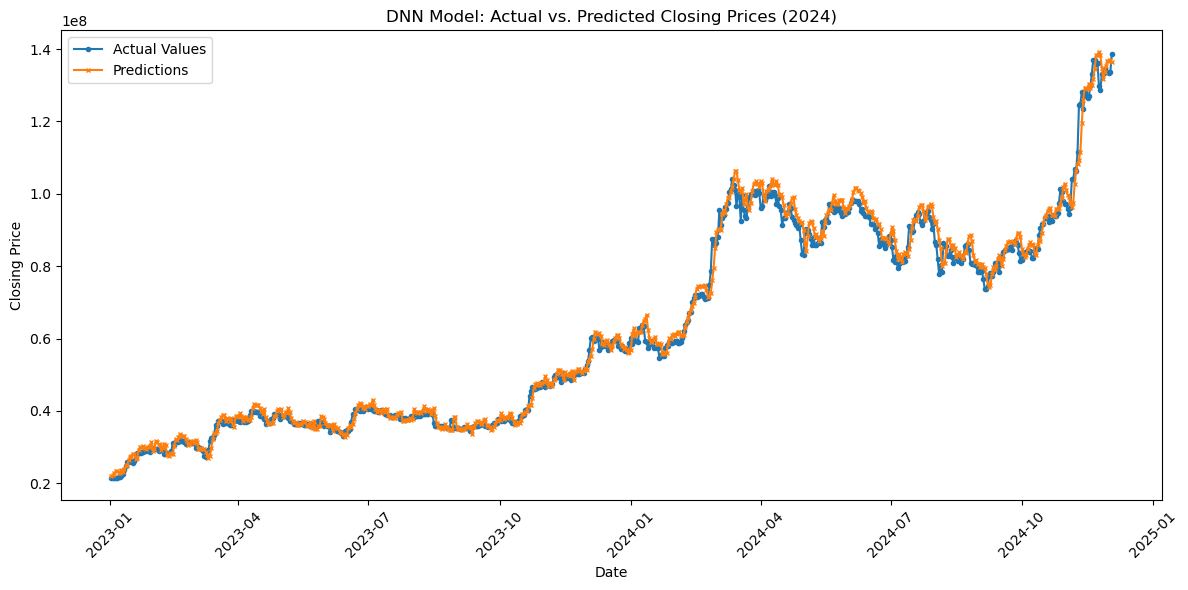

Plot saved to ./output/DNN\DNN_plot_20241230_104831.png
Model saved to ./output/DNN\DNN_model_20241230_104831.pth


In [3]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 일별 데이터 집계
df['date'] = df['datetime'].dt.date
daily_df = df.groupby('date').agg({
    'opening_price': 'first',
    'closing_price': 'last',
    'high_price': 'max',
    'low_price': 'min',
    'trade_volume': 'sum',
    'year': 'first',
    'month': 'first',
    'day': 'first'
}).reset_index()

daily_df.sort_values(by='date', inplace=True)
daily_df.reset_index(drop=True, inplace=True)

# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5일 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5d_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10일 SMA 사용)
    df['10d_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10d_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10d_sma'] + 2 * df['10d_std']
    df['lower_band'] = df['10d_sma'] - 2 * df['10d_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10d_sma']

    # RSI 계산 (9일)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5일)
    df['low_5d'] = df['low_price'].rolling(window=5).min()
    df['high_5d'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5d']) / (df['high_5d'] - df['low_5d'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
daily_df = calculate_technical_indicators(daily_df)

# 데이터 분할
validation_year = 2023
train_test_df = daily_df[daily_df['year'] < validation_year]
validation_df = daily_df[daily_df['year'] >= validation_year]

train_ratio = 0.7
train_size = int(len(train_test_df) * train_ratio)
train_df = train_test_df[:train_size]
test_df = train_test_df[train_size:]


# 데이터 분할 확인
print(f"train_df length: {len(train_df)}")
print(f"test_df length: {len(test_df)}")
print(f"validation_df length: {len(validation_df)}")

# 입력 피처 선택 (논문 기반)
features = [
    'opening_price', 'closing_price', 'high_price', 'low_price', '5d_wma', 
    '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d', 'year', 'month', 'day'
]
target = 'closing_price' # 논문에서는 가격 변동을 예측하지만, 편의상 종가를 예측 목표로 설정

# 데이터 스케일링
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
validation_df[features] = scaler.transform(validation_df[features])

# 타겟 변수 생성 (다음 날 종가)
train_df['target'] = train_df['closing_price'].shift(-1)
test_df['target'] = test_df['closing_price'].shift(-1)
validation_df['target'] = validation_df['closing_price'].shift(-1)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
validation_df.dropna(inplace=True)


# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
       return len(self.target) - self.sequence_length if len(self.target) > self.sequence_length else 0
    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length]
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

sequence_length = 1
train_dataset = BitcoinDataset(train_df, features, 'target', sequence_length)
test_dataset = BitcoinDataset(test_df, features, 'target', sequence_length)
validation_dataset = BitcoinDataset(validation_df, features, 'target', sequence_length)

# 데이터 로더 생성
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
         h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         return out

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
hidden_size = 100  # 논문 기반으로 적절한 값 설정
num_layers = 5  # DNN 레이어 수 (논문 기반)
model_type = 'DNN' # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')

if model_type == 'DNN':
  model = DNN(input_size, hidden_size, num_layers).to(device)
elif model_type == 'BasicRNN':
  model = BasicRNN(input_size, hidden_size).to(device)
elif model_type == 'LSTM-RNN':
  model = LSTM_RNN(input_size, hidden_size).to(device)
elif model_type == 'GRU-RNN':
  model = GRU_RNN(input_size, hidden_size).to(device)
elif model_type == 'BidirectionalRNN':
    model = BidirectionalRNN(input_size, hidden_size).to(device)
else:
  raise ValueError("Invalid Model type")
  

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100 # 논문 기반 에폭 수

def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

def validate_model(model, validation_loader, model_type):
    model.eval()
    predictions = []
    actual_values = []
    with torch.no_grad():
        for seq_x, seq_y in validation_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(seq_y.cpu().numpy())

    return predictions, actual_values

def plot_predictions(actual_values, predictions, validation_df, model_type):
    # 시각화
    dates = validation_df['date'].values[1:]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_values, label='Actual Values', marker='o', linestyle='-', markersize=3)
    plt.plot(dates, predictions, label='Predictions', marker='x', linestyle='-', markersize=3)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'{model_type} Model: Actual vs. Predicted Closing Prices (2024)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # 이미지 저장 경로 설정
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_plot_{timestamp}.png')

    plt.savefig(output_path)
    plt.show()
    print(f"Plot saved to {output_path}")

    
if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type)
    # 모델 평가
    evaluate_model(trained_model, test_loader, criterion, model_type)
    # 모델 검증
    predictions, actual_values = validate_model(trained_model, validation_loader, model_type)
    # 예측 시각화
    plot_predictions(actual_values, predictions, validation_df, model_type)

    # 모델 저장
    model_save_path = os.path.join(f'./output/{model_type}', f'{model_type}_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

변수 임의 변경

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\3399409478.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features] = scaler.fit_transform(train_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\3399409478.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[features] = scaler.transform(test_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\3399409478.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy

train_df length: 1600
test_df length: 687
validation_df length: 339
Using device: cuda


Epoch 1/100: 100%|██████████| 160/160 [00:00<00:00, 449.72it/s]


Epoch 1/100, Average Loss: 913465264858726.3750


Epoch 2/100: 100%|██████████| 160/160 [00:00<00:00, 764.34it/s]


Epoch 2/100, Average Loss: 368314410572185.6250


Epoch 3/100: 100%|██████████| 160/160 [00:00<00:00, 756.43it/s]


Epoch 3/100, Average Loss: 211273790206771.1875


Epoch 4/100: 100%|██████████| 160/160 [00:00<00:00, 747.45it/s]


Epoch 4/100, Average Loss: 103667002179584.0000


Epoch 5/100: 100%|██████████| 160/160 [00:00<00:00, 750.26it/s]


Epoch 5/100, Average Loss: 20558998917120.0000


Epoch 6/100: 100%|██████████| 160/160 [00:00<00:00, 760.69it/s]


Epoch 6/100, Average Loss: 7609978681753.5996


Epoch 7/100: 100%|██████████| 160/160 [00:00<00:00, 764.60it/s]


Epoch 7/100, Average Loss: 6326443587788.7998


Epoch 8/100: 100%|██████████| 160/160 [00:00<00:00, 753.55it/s]


Epoch 8/100, Average Loss: 5504025478348.7998


Epoch 9/100: 100%|██████████| 160/160 [00:00<00:00, 674.27it/s]


Epoch 9/100, Average Loss: 4962479550873.5996


Epoch 10/100: 100%|██████████| 160/160 [00:00<00:00, 666.67it/s]


Epoch 10/100, Average Loss: 4482857465036.7998


Epoch 11/100: 100%|██████████| 160/160 [00:00<00:00, 679.83it/s]


Epoch 11/100, Average Loss: 4097342319820.7998


Epoch 12/100: 100%|██████████| 160/160 [00:00<00:00, 744.33it/s]


Epoch 12/100, Average Loss: 3870117278105.6001


Epoch 13/100: 100%|██████████| 160/160 [00:00<00:00, 749.29it/s]


Epoch 13/100, Average Loss: 3657847732531.2002


Epoch 14/100: 100%|██████████| 160/160 [00:00<00:00, 769.13it/s]


Epoch 14/100, Average Loss: 3735116782182.3999


Epoch 15/100: 100%|██████████| 160/160 [00:00<00:00, 772.85it/s]


Epoch 15/100, Average Loss: 3449691091763.2002


Epoch 16/100: 100%|██████████| 160/160 [00:00<00:00, 773.68it/s]


Epoch 16/100, Average Loss: 3297080398950.3999


Epoch 17/100: 100%|██████████| 160/160 [00:00<00:00, 761.33it/s]


Epoch 17/100, Average Loss: 3270386745139.2002


Epoch 18/100: 100%|██████████| 160/160 [00:00<00:00, 704.27it/s]


Epoch 18/100, Average Loss: 3283483705344.0000


Epoch 19/100: 100%|██████████| 160/160 [00:00<00:00, 598.27it/s]


Epoch 19/100, Average Loss: 3190000819302.3999


Epoch 20/100: 100%|██████████| 160/160 [00:00<00:00, 619.03it/s]


Epoch 20/100, Average Loss: 3103738776166.3999


Epoch 21/100: 100%|██████████| 160/160 [00:00<00:00, 718.70it/s]


Epoch 21/100, Average Loss: 3095859709440.0000


Epoch 22/100: 100%|██████████| 160/160 [00:00<00:00, 754.68it/s]


Epoch 22/100, Average Loss: 3054363525324.7998


Epoch 23/100: 100%|██████████| 160/160 [00:00<00:00, 767.41it/s]


Epoch 23/100, Average Loss: 3237941214617.6001


Epoch 24/100: 100%|██████████| 160/160 [00:00<00:00, 756.83it/s]


Epoch 24/100, Average Loss: 3035647910092.7998


Epoch 25/100: 100%|██████████| 160/160 [00:00<00:00, 761.30it/s]


Epoch 25/100, Average Loss: 3099125782732.7998


Epoch 26/100: 100%|██████████| 160/160 [00:00<00:00, 777.23it/s]


Epoch 26/100, Average Loss: 3230800640358.3999


Epoch 27/100: 100%|██████████| 160/160 [00:00<00:00, 722.49it/s]


Epoch 27/100, Average Loss: 2970473699328.0000


Epoch 28/100: 100%|██████████| 160/160 [00:00<00:00, 785.01it/s]


Epoch 28/100, Average Loss: 3012897526579.2002


Epoch 29/100: 100%|██████████| 160/160 [00:00<00:00, 654.78it/s]


Epoch 29/100, Average Loss: 2917468165734.3999


Epoch 30/100: 100%|██████████| 160/160 [00:00<00:00, 606.70it/s]


Epoch 30/100, Average Loss: 2939523948800.0000


Epoch 31/100: 100%|██████████| 160/160 [00:00<00:00, 608.71it/s]


Epoch 31/100, Average Loss: 2960560506572.7998


Epoch 32/100: 100%|██████████| 160/160 [00:00<00:00, 662.47it/s]


Epoch 32/100, Average Loss: 3124870135347.2002


Epoch 33/100: 100%|██████████| 160/160 [00:00<00:00, 626.91it/s]


Epoch 33/100, Average Loss: 2786682102169.6001


Epoch 34/100: 100%|██████████| 160/160 [00:00<00:00, 782.33it/s]


Epoch 34/100, Average Loss: 2899319041280.0000


Epoch 35/100: 100%|██████████| 160/160 [00:00<00:00, 757.29it/s]


Epoch 35/100, Average Loss: 3085004318003.2002


Epoch 36/100: 100%|██████████| 160/160 [00:00<00:00, 761.22it/s]


Epoch 36/100, Average Loss: 2919430072780.7998


Epoch 37/100: 100%|██████████| 160/160 [00:00<00:00, 780.97it/s]


Epoch 37/100, Average Loss: 3003986815692.7998


Epoch 38/100: 100%|██████████| 160/160 [00:00<00:00, 780.51it/s]


Epoch 38/100, Average Loss: 2932123598899.2002


Epoch 39/100: 100%|██████████| 160/160 [00:00<00:00, 774.72it/s]


Epoch 39/100, Average Loss: 2975786883379.2002


Epoch 40/100: 100%|██████████| 160/160 [00:00<00:00, 702.29it/s]


Epoch 40/100, Average Loss: 2888208355020.7998


Epoch 41/100: 100%|██████████| 160/160 [00:00<00:00, 747.76it/s]


Epoch 41/100, Average Loss: 2890304356044.7998


Epoch 42/100: 100%|██████████| 160/160 [00:00<00:00, 662.69it/s]


Epoch 42/100, Average Loss: 2896554753740.7998


Epoch 43/100: 100%|██████████| 160/160 [00:00<00:00, 571.43it/s]


Epoch 43/100, Average Loss: 2960001727232.0000


Epoch 44/100: 100%|██████████| 160/160 [00:00<00:00, 712.19it/s]


Epoch 44/100, Average Loss: 2889132768921.6001


Epoch 45/100: 100%|██████████| 160/160 [00:00<00:00, 734.49it/s]


Epoch 45/100, Average Loss: 2915327256627.2002


Epoch 46/100: 100%|██████████| 160/160 [00:00<00:00, 737.44it/s]


Epoch 46/100, Average Loss: 3091125936844.7998


Epoch 47/100: 100%|██████████| 160/160 [00:00<00:00, 734.33it/s]


Epoch 47/100, Average Loss: 2870839813017.6001


Epoch 48/100: 100%|██████████| 160/160 [00:00<00:00, 733.89it/s]


Epoch 48/100, Average Loss: 2863170166835.2002


Epoch 49/100: 100%|██████████| 160/160 [00:00<00:00, 684.54it/s]


Epoch 49/100, Average Loss: 2854029319168.0000


Epoch 50/100: 100%|██████████| 160/160 [00:00<00:00, 733.65it/s]


Epoch 50/100, Average Loss: 2795560260147.2002


Epoch 51/100: 100%|██████████| 160/160 [00:00<00:00, 736.45it/s]


Epoch 51/100, Average Loss: 2821921410508.7998


Epoch 52/100: 100%|██████████| 160/160 [00:00<00:00, 621.60it/s]


Epoch 52/100, Average Loss: 2830499535155.2002


Epoch 53/100: 100%|██████████| 160/160 [00:00<00:00, 581.78it/s]


Epoch 53/100, Average Loss: 3046045271244.7998


Epoch 54/100: 100%|██████████| 160/160 [00:00<00:00, 605.60it/s]


Epoch 54/100, Average Loss: 2846785331916.7998


Epoch 55/100: 100%|██████████| 160/160 [00:00<00:00, 633.06it/s]


Epoch 55/100, Average Loss: 2803947513651.2002


Epoch 56/100: 100%|██████████| 160/160 [00:00<00:00, 732.54it/s]


Epoch 56/100, Average Loss: 2923901592678.3999


Epoch 57/100: 100%|██████████| 160/160 [00:00<00:00, 732.59it/s]


Epoch 57/100, Average Loss: 2850680244889.6001


Epoch 58/100: 100%|██████████| 160/160 [00:00<00:00, 742.10it/s]


Epoch 58/100, Average Loss: 2832638919270.3999


Epoch 59/100: 100%|██████████| 160/160 [00:00<00:00, 695.26it/s]


Epoch 59/100, Average Loss: 2922769961574.3999


Epoch 60/100: 100%|██████████| 160/160 [00:00<00:00, 748.05it/s]


Epoch 60/100, Average Loss: 2946826799308.7998


Epoch 61/100: 100%|██████████| 160/160 [00:00<00:00, 742.24it/s]


Epoch 61/100, Average Loss: 2784202205798.3999


Epoch 62/100: 100%|██████████| 160/160 [00:00<00:00, 731.01it/s]


Epoch 62/100, Average Loss: 2777646642688.0000


Epoch 63/100: 100%|██████████| 160/160 [00:00<00:00, 738.05it/s]


Epoch 63/100, Average Loss: 2935177978982.3999


Epoch 64/100: 100%|██████████| 160/160 [00:00<00:00, 600.72it/s]


Epoch 64/100, Average Loss: 2930532178227.2002


Epoch 65/100: 100%|██████████| 160/160 [00:00<00:00, 583.96it/s]


Epoch 65/100, Average Loss: 2807283338240.0000


Epoch 66/100: 100%|██████████| 160/160 [00:00<00:00, 628.77it/s]


Epoch 66/100, Average Loss: 2935871400601.6001


Epoch 67/100: 100%|██████████| 160/160 [00:00<00:00, 595.99it/s]


Epoch 67/100, Average Loss: 2958149773926.3999


Epoch 68/100: 100%|██████████| 160/160 [00:00<00:00, 647.40it/s]


Epoch 68/100, Average Loss: 2802900667801.6001


Epoch 69/100: 100%|██████████| 160/160 [00:00<00:00, 684.91it/s]


Epoch 69/100, Average Loss: 2788883221196.7998


Epoch 70/100: 100%|██████████| 160/160 [00:00<00:00, 734.83it/s]


Epoch 70/100, Average Loss: 2911180789606.3999


Epoch 71/100: 100%|██████████| 160/160 [00:00<00:00, 749.05it/s]


Epoch 71/100, Average Loss: 2718419496345.6001


Epoch 72/100: 100%|██████████| 160/160 [00:00<00:00, 768.26it/s]


Epoch 72/100, Average Loss: 2955113536409.6001


Epoch 73/100: 100%|██████████| 160/160 [00:00<00:00, 771.26it/s]


Epoch 73/100, Average Loss: 2865668465612.7998


Epoch 74/100: 100%|██████████| 160/160 [00:00<00:00, 772.16it/s]


Epoch 74/100, Average Loss: 2789595245260.7998


Epoch 75/100: 100%|██████████| 160/160 [00:00<00:00, 761.48it/s]


Epoch 75/100, Average Loss: 2748304118579.2002


Epoch 76/100: 100%|██████████| 160/160 [00:00<00:00, 746.13it/s]


Epoch 76/100, Average Loss: 2860820226355.2002


Epoch 77/100: 100%|██████████| 160/160 [00:00<00:00, 635.45it/s]


Epoch 77/100, Average Loss: 2813888242278.3999


Epoch 78/100: 100%|██████████| 160/160 [00:00<00:00, 646.39it/s]


Epoch 78/100, Average Loss: 2883069758156.7998


Epoch 79/100: 100%|██████████| 160/160 [00:00<00:00, 612.52it/s]


Epoch 79/100, Average Loss: 2801353252966.3999


Epoch 80/100: 100%|██████████| 160/160 [00:00<00:00, 764.53it/s]


Epoch 80/100, Average Loss: 2964250197504.0000


Epoch 81/100: 100%|██████████| 160/160 [00:00<00:00, 784.52it/s]


Epoch 81/100, Average Loss: 2973169105510.3999


Epoch 82/100: 100%|██████████| 160/160 [00:00<00:00, 788.71it/s]


Epoch 82/100, Average Loss: 2905291212595.2002


Epoch 83/100: 100%|██████████| 160/160 [00:00<00:00, 778.84it/s]


Epoch 83/100, Average Loss: 2731008918118.3999


Epoch 84/100: 100%|██████████| 160/160 [00:00<00:00, 759.02it/s]


Epoch 84/100, Average Loss: 2785933549363.2002


Epoch 85/100: 100%|██████████| 160/160 [00:00<00:00, 773.90it/s]


Epoch 85/100, Average Loss: 2854608473088.0000


Epoch 86/100: 100%|██████████| 160/160 [00:00<00:00, 780.80it/s]


Epoch 86/100, Average Loss: 3017601312025.6001


Epoch 87/100: 100%|██████████| 160/160 [00:00<00:00, 782.94it/s]


Epoch 87/100, Average Loss: 2848374308966.3999


Epoch 88/100: 100%|██████████| 160/160 [00:00<00:00, 752.74it/s]


Epoch 88/100, Average Loss: 2859929446195.2002


Epoch 89/100: 100%|██████████| 160/160 [00:00<00:00, 606.92it/s]


Epoch 89/100, Average Loss: 2933010383027.2002


Epoch 90/100: 100%|██████████| 160/160 [00:00<00:00, 639.00it/s]


Epoch 90/100, Average Loss: 2941372189235.2002


Epoch 91/100: 100%|██████████| 160/160 [00:00<00:00, 635.92it/s]


Epoch 91/100, Average Loss: 2855012070400.0000


Epoch 92/100: 100%|██████████| 160/160 [00:00<00:00, 672.40it/s]


Epoch 92/100, Average Loss: 2769666889062.3999


Epoch 93/100: 100%|██████████| 160/160 [00:00<00:00, 679.02it/s]


Epoch 93/100, Average Loss: 2829654957568.0000


Epoch 94/100: 100%|██████████| 160/160 [00:00<00:00, 638.47it/s]


Epoch 94/100, Average Loss: 2907437822105.6001


Epoch 95/100: 100%|██████████| 160/160 [00:00<00:00, 747.36it/s]


Epoch 95/100, Average Loss: 2802396096486.3999


Epoch 96/100: 100%|██████████| 160/160 [00:00<00:00, 779.72it/s]


Epoch 96/100, Average Loss: 2931359798272.0000


Epoch 97/100: 100%|██████████| 160/160 [00:00<00:00, 776.95it/s]


Epoch 97/100, Average Loss: 2789760701363.2002


Epoch 98/100: 100%|██████████| 160/160 [00:00<00:00, 768.16it/s]


Epoch 98/100, Average Loss: 2829202669312.0000


Epoch 99/100: 100%|██████████| 160/160 [00:00<00:00, 754.68it/s]


Epoch 99/100, Average Loss: 2800251599692.7998


Epoch 100/100: 100%|██████████| 160/160 [00:00<00:00, 727.95it/s]


Epoch 100/100, Average Loss: 2849461460787.2002
Test Loss: 2109435626303.0725


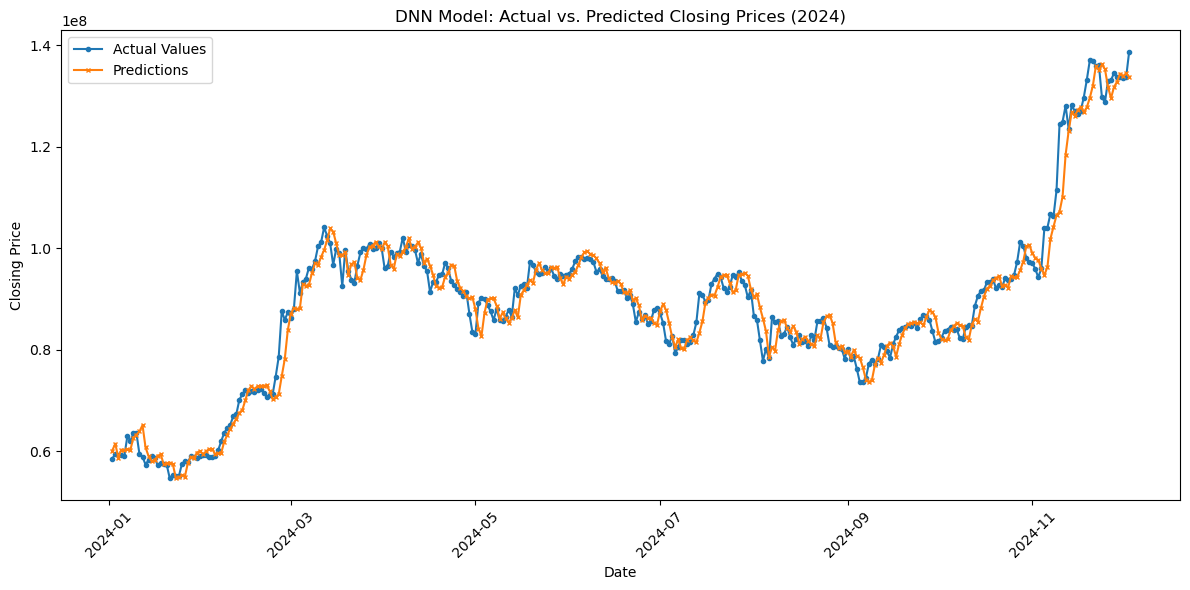

Plot saved to ./output/DNN\DNN_plot_20241230_110246.png
Model saved to ./output/DNN\DNN_model_20241230_110247.pth


In [5]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 일별 데이터 집계
df['date'] = df['datetime'].dt.date
daily_df = df.groupby('date').agg({
    'opening_price': 'first',
    'closing_price': 'last',
    'high_price': 'max',
    'low_price': 'min',
    'trade_volume': 'sum',
    'year': 'first',
    'month': 'first',
    'day': 'first'
}).reset_index()

daily_df.sort_values(by='date', inplace=True)
daily_df.reset_index(drop=True, inplace=True)

# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5일 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5d_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10일 SMA 사용)
    df['10d_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10d_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10d_sma'] + 2 * df['10d_std']
    df['lower_band'] = df['10d_sma'] - 2 * df['10d_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10d_sma']

    # RSI 계산 (9일)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5일)
    df['low_5d'] = df['low_price'].rolling(window=5).min()
    df['high_5d'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5d']) / (df['high_5d'] - df['low_5d'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
daily_df = calculate_technical_indicators(daily_df)

# 데이터 분할
validation_year = 2024
train_test_df = daily_df[daily_df['year'] < validation_year]
validation_df = daily_df[daily_df['year'] == validation_year]

train_ratio = 0.7
train_size = int(len(train_test_df) * train_ratio)
train_df = train_test_df[:train_size]
test_df = train_test_df[train_size:]


# 데이터 분할 확인
print(f"train_df length: {len(train_df)}")
print(f"test_df length: {len(test_df)}")
print(f"validation_df length: {len(validation_df)}")

# 입력 피처 선택 (논문 기반)
features = [
    'high_price', 'low_price', '5d_wma', 
    '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d', 'year', 'month', 'day'
]
target = 'closing_price' # 논문에서는 가격 변동을 예측하지만, 편의상 종가를 예측 목표로 설정

# 데이터 스케일링
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
validation_df[features] = scaler.transform(validation_df[features])

# 타겟 변수 생성 (다음 날 종가)
train_df['target'] = train_df['closing_price'].shift(-1)
test_df['target'] = test_df['closing_price'].shift(-1)
validation_df['target'] = validation_df['closing_price'].shift(-1)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
validation_df.dropna(inplace=True)


# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
       return len(self.target) - self.sequence_length if len(self.target) > self.sequence_length else 0
    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length]
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

sequence_length = 1
train_dataset = BitcoinDataset(train_df, features, 'target', sequence_length)
test_dataset = BitcoinDataset(test_df, features, 'target', sequence_length)
validation_dataset = BitcoinDataset(validation_df, features, 'target', sequence_length)

# 데이터 로더 생성
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
         h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         return out

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
hidden_size = 100  # 논문 기반으로 적절한 값 설정
num_layers = 5  # DNN 레이어 수 (논문 기반)
model_type = 'DNN' # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')

if model_type == 'DNN':
  model = DNN(input_size, hidden_size, num_layers).to(device)
elif model_type == 'BasicRNN':
  model = BasicRNN(input_size, hidden_size).to(device)
elif model_type == 'LSTM-RNN':
  model = LSTM_RNN(input_size, hidden_size).to(device)
elif model_type == 'GRU-RNN':
  model = GRU_RNN(input_size, hidden_size).to(device)
elif model_type == 'BidirectionalRNN':
    model = BidirectionalRNN(input_size, hidden_size).to(device)
else:
  raise ValueError("Invalid Model type")
  

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100 # 논문 기반 에폭 수

def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

def validate_model(model, validation_loader, model_type):
    model.eval()
    predictions = []
    actual_values = []
    with torch.no_grad():
        for seq_x, seq_y in validation_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(seq_y.cpu().numpy())

    return predictions, actual_values

def plot_predictions(actual_values, predictions, validation_df, model_type):
    # 시각화
    dates = validation_df['date'].values[1:]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_values, label='Actual Values', marker='o', linestyle='-', markersize=3)
    plt.plot(dates, predictions, label='Predictions', marker='x', linestyle='-', markersize=3)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'{model_type} Model: Actual vs. Predicted Closing Prices (2024)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # 이미지 저장 경로 설정
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_plot_{timestamp}.png')

    plt.savefig(output_path)
    plt.show()
    print(f"Plot saved to {output_path}")

    
if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type)
    # 모델 평가
    evaluate_model(trained_model, test_loader, criterion, model_type)
    # 모델 검증
    predictions, actual_values = validate_model(trained_model, validation_loader, model_type)
    # 예측 시각화
    plot_predictions(actual_values, predictions, validation_df, model_type)

    # 모델 저장
    model_save_path = os.path.join(f'./output/{model_type}', f'{model_type}_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\1599371930.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features] = scaler.fit_transform(train_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\1599371930.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[features] = scaler.transform(test_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\1599371930.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy

train_df length: 1600
test_df length: 687
validation_df length: 339
Using device: cuda


Epoch 1/100: 100%|██████████| 160/160 [00:00<00:00, 472.39it/s]


Epoch 1/100, Average Loss: 926847058706432.0000


Epoch 2/100: 100%|██████████| 160/160 [00:00<00:00, 798.85it/s]


Epoch 2/100, Average Loss: 511891281870848.0000


Epoch 3/100: 100%|██████████| 160/160 [00:00<00:00, 768.59it/s]


Epoch 3/100, Average Loss: 355426571806310.3750


Epoch 4/100: 100%|██████████| 160/160 [00:00<00:00, 773.40it/s]


Epoch 4/100, Average Loss: 319004515552460.8125


Epoch 5/100: 100%|██████████| 160/160 [00:00<00:00, 768.19it/s]


Epoch 5/100, Average Loss: 273795144744960.0000


Epoch 6/100: 100%|██████████| 160/160 [00:00<00:00, 763.04it/s]


Epoch 6/100, Average Loss: 206632055000268.8125


Epoch 7/100: 100%|██████████| 160/160 [00:00<00:00, 749.24it/s]


Epoch 7/100, Average Loss: 114979467060838.4062


Epoch 8/100: 100%|██████████| 160/160 [00:00<00:00, 760.02it/s]


Epoch 8/100, Average Loss: 46128414153113.6016


Epoch 9/100: 100%|██████████| 160/160 [00:00<00:00, 658.81it/s]


Epoch 9/100, Average Loss: 25461754593280.0000


Epoch 10/100: 100%|██████████| 160/160 [00:00<00:00, 699.10it/s]


Epoch 10/100, Average Loss: 19300962593996.8008


Epoch 11/100: 100%|██████████| 160/160 [00:00<00:00, 738.25it/s]


Epoch 11/100, Average Loss: 15354218944921.5996


Epoch 12/100: 100%|██████████| 160/160 [00:00<00:00, 768.87it/s]


Epoch 12/100, Average Loss: 12726748988211.1992


Epoch 13/100: 100%|██████████| 160/160 [00:00<00:00, 732.20it/s]


Epoch 13/100, Average Loss: 10800072855552.0000


Epoch 14/100: 100%|██████████| 160/160 [00:00<00:00, 725.11it/s]


Epoch 14/100, Average Loss: 9373013910323.1992


Epoch 15/100: 100%|██████████| 160/160 [00:00<00:00, 720.32it/s]


Epoch 15/100, Average Loss: 8170130005606.4004


Epoch 16/100: 100%|██████████| 160/160 [00:00<00:00, 762.83it/s]


Epoch 16/100, Average Loss: 7307312570368.0000


Epoch 17/100: 100%|██████████| 160/160 [00:00<00:00, 758.51it/s]


Epoch 17/100, Average Loss: 6695442448179.2002


Epoch 18/100: 100%|██████████| 160/160 [00:00<00:00, 597.79it/s]


Epoch 18/100, Average Loss: 6186685821747.2002


Epoch 19/100: 100%|██████████| 160/160 [00:00<00:00, 593.05it/s]


Epoch 19/100, Average Loss: 5837806061568.0000


Epoch 20/100: 100%|██████████| 160/160 [00:00<00:00, 711.97it/s]


Epoch 20/100, Average Loss: 5510615687577.5996


Epoch 21/100: 100%|██████████| 160/160 [00:00<00:00, 720.67it/s]


Epoch 21/100, Average Loss: 5346649212108.7998


Epoch 22/100: 100%|██████████| 160/160 [00:00<00:00, 733.57it/s]


Epoch 22/100, Average Loss: 5043941563596.7998


Epoch 23/100: 100%|██████████| 160/160 [00:00<00:00, 739.51it/s]


Epoch 23/100, Average Loss: 4921736517632.0000


Epoch 24/100: 100%|██████████| 160/160 [00:00<00:00, 727.83it/s]


Epoch 24/100, Average Loss: 4764366029209.5996


Epoch 25/100: 100%|██████████| 160/160 [00:00<00:00, 736.22it/s]


Epoch 25/100, Average Loss: 4570998450790.4004


Epoch 26/100: 100%|██████████| 160/160 [00:00<00:00, 709.25it/s]


Epoch 26/100, Average Loss: 4567536080076.7998


Epoch 27/100: 100%|██████████| 160/160 [00:00<00:00, 786.17it/s]


Epoch 27/100, Average Loss: 4450498857779.2002


Epoch 28/100: 100%|██████████| 160/160 [00:00<00:00, 587.50it/s]


Epoch 28/100, Average Loss: 4232274363187.2002


Epoch 29/100: 100%|██████████| 160/160 [00:00<00:00, 628.98it/s]


Epoch 29/100, Average Loss: 4141166464512.0000


Epoch 30/100: 100%|██████████| 160/160 [00:00<00:00, 720.00it/s]


Epoch 30/100, Average Loss: 4041092929126.3999


Epoch 31/100: 100%|██████████| 160/160 [00:00<00:00, 773.63it/s]


Epoch 31/100, Average Loss: 4044247285760.0000


Epoch 32/100: 100%|██████████| 160/160 [00:00<00:00, 800.05it/s]


Epoch 32/100, Average Loss: 3993996009062.3999


Epoch 33/100: 100%|██████████| 160/160 [00:00<00:00, 758.46it/s]


Epoch 33/100, Average Loss: 3914634549452.7998


Epoch 34/100: 100%|██████████| 160/160 [00:00<00:00, 804.30it/s]


Epoch 34/100, Average Loss: 3757954179276.7998


Epoch 35/100: 100%|██████████| 160/160 [00:00<00:00, 774.22it/s]


Epoch 35/100, Average Loss: 3680577624883.2002


Epoch 36/100: 100%|██████████| 160/160 [00:00<00:00, 760.18it/s]


Epoch 36/100, Average Loss: 3736613381120.0000


Epoch 37/100: 100%|██████████| 160/160 [00:00<00:00, 740.34it/s]


Epoch 37/100, Average Loss: 3598086252236.7998


Epoch 38/100: 100%|██████████| 160/160 [00:00<00:00, 724.30it/s]


Epoch 38/100, Average Loss: 3773594186547.2002


Epoch 39/100: 100%|██████████| 160/160 [00:00<00:00, 636.66it/s]


Epoch 39/100, Average Loss: 3604150752256.0000


Epoch 40/100: 100%|██████████| 160/160 [00:00<00:00, 632.99it/s]


Epoch 40/100, Average Loss: 3521417215180.7998


Epoch 41/100: 100%|██████████| 160/160 [00:00<00:00, 695.91it/s]


Epoch 41/100, Average Loss: 3471251186483.2002


Epoch 42/100: 100%|██████████| 160/160 [00:00<00:00, 787.85it/s]


Epoch 42/100, Average Loss: 3413019349401.6001


Epoch 43/100: 100%|██████████| 160/160 [00:00<00:00, 787.20it/s]


Epoch 43/100, Average Loss: 3490947061760.0000


Epoch 44/100: 100%|██████████| 160/160 [00:00<00:00, 795.12it/s]


Epoch 44/100, Average Loss: 3393392257638.3999


Epoch 45/100: 100%|██████████| 160/160 [00:00<00:00, 782.12it/s]


Epoch 45/100, Average Loss: 3393172823040.0000


Epoch 46/100: 100%|██████████| 160/160 [00:00<00:00, 754.66it/s]


Epoch 46/100, Average Loss: 3344121487360.0000


Epoch 47/100: 100%|██████████| 160/160 [00:00<00:00, 776.68it/s]


Epoch 47/100, Average Loss: 3237737602867.2002


Epoch 48/100: 100%|██████████| 160/160 [00:00<00:00, 692.38it/s]


Epoch 48/100, Average Loss: 3303654651392.0000


Epoch 49/100: 100%|██████████| 160/160 [00:00<00:00, 764.58it/s]


Epoch 49/100, Average Loss: 3231934952448.0000


Epoch 50/100: 100%|██████████| 160/160 [00:00<00:00, 597.84it/s]


Epoch 50/100, Average Loss: 3199818299494.3999


Epoch 51/100: 100%|██████████| 160/160 [00:00<00:00, 659.46it/s]


Epoch 51/100, Average Loss: 3198085733580.7998


Epoch 52/100: 100%|██████████| 160/160 [00:00<00:00, 626.40it/s]


Epoch 52/100, Average Loss: 3267725222707.2002


Epoch 53/100: 100%|██████████| 160/160 [00:00<00:00, 762.17it/s]


Epoch 53/100, Average Loss: 3108357997056.0000


Epoch 54/100: 100%|██████████| 160/160 [00:00<00:00, 768.36it/s]


Epoch 54/100, Average Loss: 3125948092211.2002


Epoch 55/100: 100%|██████████| 160/160 [00:00<00:00, 755.72it/s]


Epoch 55/100, Average Loss: 3148577633331.2002


Epoch 56/100: 100%|██████████| 160/160 [00:00<00:00, 765.87it/s]


Epoch 56/100, Average Loss: 3293976607129.6001


Epoch 57/100: 100%|██████████| 160/160 [00:00<00:00, 767.86it/s]


Epoch 57/100, Average Loss: 3127801900953.6001


Epoch 58/100: 100%|██████████| 160/160 [00:00<00:00, 683.13it/s]


Epoch 58/100, Average Loss: 3088214269542.3999


Epoch 59/100: 100%|██████████| 160/160 [00:00<00:00, 739.34it/s]


Epoch 59/100, Average Loss: 3060554593792.0000


Epoch 60/100: 100%|██████████| 160/160 [00:00<00:00, 737.20it/s]


Epoch 60/100, Average Loss: 3065940853248.0000


Epoch 61/100: 100%|██████████| 160/160 [00:00<00:00, 675.79it/s]


Epoch 61/100, Average Loss: 3215918013542.3999


Epoch 62/100: 100%|██████████| 160/160 [00:00<00:00, 587.38it/s]


Epoch 62/100, Average Loss: 3042708727193.6001


Epoch 63/100: 100%|██████████| 160/160 [00:00<00:00, 602.64it/s]


Epoch 63/100, Average Loss: 3020125147238.3999


Epoch 64/100: 100%|██████████| 160/160 [00:00<00:00, 590.22it/s]


Epoch 64/100, Average Loss: 3123443986022.3999


Epoch 65/100: 100%|██████████| 160/160 [00:00<00:00, 710.95it/s]


Epoch 65/100, Average Loss: 3117880964198.3999


Epoch 66/100: 100%|██████████| 160/160 [00:00<00:00, 740.40it/s]


Epoch 66/100, Average Loss: 3015966586060.7998


Epoch 67/100: 100%|██████████| 160/160 [00:00<00:00, 732.83it/s]


Epoch 67/100, Average Loss: 2970757773824.0000


Epoch 68/100: 100%|██████████| 160/160 [00:00<00:00, 693.45it/s]


Epoch 68/100, Average Loss: 2951385940582.3999


Epoch 69/100: 100%|██████████| 160/160 [00:00<00:00, 734.25it/s]


Epoch 69/100, Average Loss: 3063510815744.0000


Epoch 70/100: 100%|██████████| 160/160 [00:00<00:00, 727.66it/s]


Epoch 70/100, Average Loss: 3141345855180.7998


Epoch 71/100: 100%|██████████| 160/160 [00:00<00:00, 728.32it/s]


Epoch 71/100, Average Loss: 3090704072089.6001


Epoch 72/100: 100%|██████████| 160/160 [00:00<00:00, 737.38it/s]


Epoch 72/100, Average Loss: 3025951581798.3999


Epoch 73/100: 100%|██████████| 160/160 [00:00<00:00, 654.91it/s]


Epoch 73/100, Average Loss: 3065803910400.0000


Epoch 74/100: 100%|██████████| 160/160 [00:00<00:00, 592.08it/s]


Epoch 74/100, Average Loss: 3131366025011.2002


Epoch 75/100: 100%|██████████| 160/160 [00:00<00:00, 620.40it/s]


Epoch 75/100, Average Loss: 2977031176115.2002


Epoch 76/100: 100%|██████████| 160/160 [00:00<00:00, 617.31it/s]


Epoch 76/100, Average Loss: 3019490523136.0000


Epoch 77/100: 100%|██████████| 160/160 [00:00<00:00, 568.13it/s]


Epoch 77/100, Average Loss: 2959434071142.3999


Epoch 78/100: 100%|██████████| 160/160 [00:00<00:00, 598.31it/s]


Epoch 78/100, Average Loss: 2997184458547.2002


Epoch 79/100: 100%|██████████| 160/160 [00:00<00:00, 636.77it/s]


Epoch 79/100, Average Loss: 2874957588070.3999


Epoch 80/100: 100%|██████████| 160/160 [00:00<00:00, 588.99it/s]


Epoch 80/100, Average Loss: 2951960071987.2002


Epoch 81/100: 100%|██████████| 160/160 [00:00<00:00, 731.55it/s]


Epoch 81/100, Average Loss: 2949452034252.7998


Epoch 82/100: 100%|██████████| 160/160 [00:00<00:00, 743.46it/s]


Epoch 82/100, Average Loss: 2988726759731.2002


Epoch 83/100: 100%|██████████| 160/160 [00:00<00:00, 737.46it/s]


Epoch 83/100, Average Loss: 2982241110835.2002


Epoch 84/100: 100%|██████████| 160/160 [00:00<00:00, 772.05it/s]


Epoch 84/100, Average Loss: 2929171575603.2002


Epoch 85/100: 100%|██████████| 160/160 [00:00<00:00, 744.66it/s]


Epoch 85/100, Average Loss: 2966964490752.0000


Epoch 86/100: 100%|██████████| 160/160 [00:00<00:00, 762.40it/s]


Epoch 86/100, Average Loss: 2856612499430.3999


Epoch 87/100: 100%|██████████| 160/160 [00:00<00:00, 745.20it/s]


Epoch 87/100, Average Loss: 2931572063436.7998


Epoch 88/100: 100%|██████████| 160/160 [00:00<00:00, 782.47it/s]


Epoch 88/100, Average Loss: 2938437711052.7998


Epoch 89/100: 100%|██████████| 160/160 [00:00<00:00, 634.11it/s]


Epoch 89/100, Average Loss: 2867437557043.2002


Epoch 90/100: 100%|██████████| 160/160 [00:00<00:00, 619.78it/s]


Epoch 90/100, Average Loss: 3051661805824.0000


Epoch 91/100: 100%|██████████| 160/160 [00:00<00:00, 687.44it/s]


Epoch 91/100, Average Loss: 2887417661132.7998


Epoch 92/100: 100%|██████████| 160/160 [00:00<00:00, 754.28it/s]


Epoch 92/100, Average Loss: 2880263881728.0000


Epoch 93/100: 100%|██████████| 160/160 [00:00<00:00, 760.01it/s]


Epoch 93/100, Average Loss: 2829813188096.0000


Epoch 94/100: 100%|██████████| 160/160 [00:00<00:00, 765.84it/s]


Epoch 94/100, Average Loss: 2952262029516.7998


Epoch 95/100: 100%|██████████| 160/160 [00:00<00:00, 761.13it/s]


Epoch 95/100, Average Loss: 2846378471987.2002


Epoch 96/100: 100%|██████████| 160/160 [00:00<00:00, 738.77it/s]


Epoch 96/100, Average Loss: 2839901162649.6001


Epoch 97/100: 100%|██████████| 160/160 [00:00<00:00, 780.94it/s]


Epoch 97/100, Average Loss: 2951623872102.3999


Epoch 98/100: 100%|██████████| 160/160 [00:00<00:00, 780.96it/s]


Epoch 98/100, Average Loss: 2795531240320.0000


Epoch 99/100: 100%|██████████| 160/160 [00:00<00:00, 760.39it/s]


Epoch 99/100, Average Loss: 2739039202662.3999


Epoch 100/100: 100%|██████████| 160/160 [00:00<00:00, 617.54it/s]


Epoch 100/100, Average Loss: 2746184059852.7998
Test Loss: 8324436187878.0293


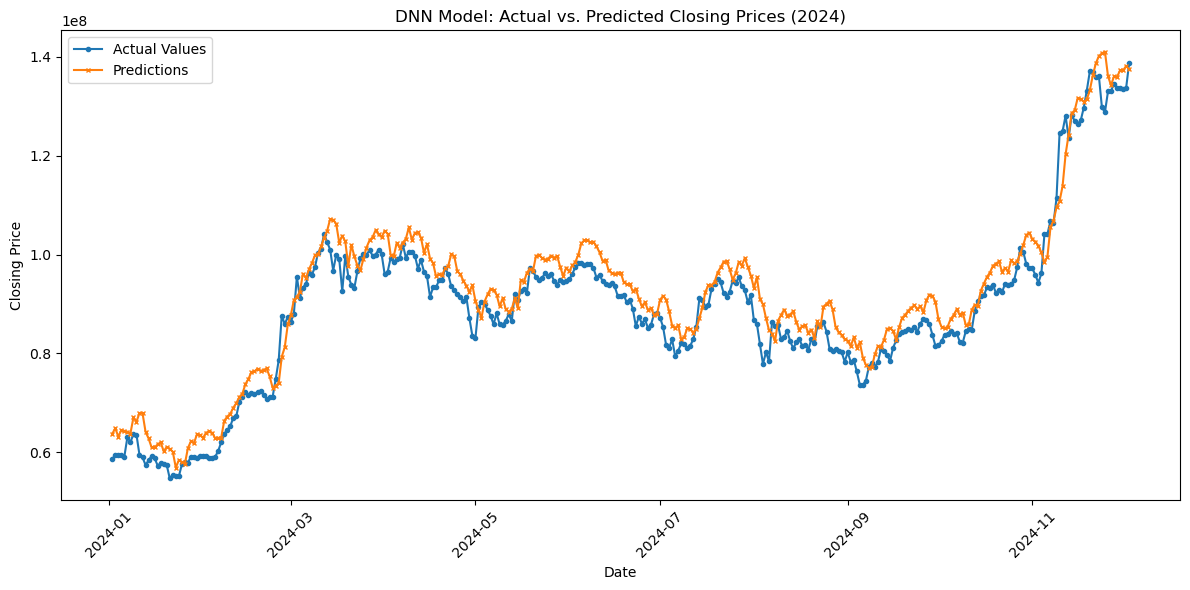

Plot saved to ./output/DNN\DNN_plot_20241230_110439.png
Model saved to ./output/DNN\DNN_model_20241230_110440.pth


In [6]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 일별 데이터 집계
df['date'] = df['datetime'].dt.date
daily_df = df.groupby('date').agg({
    'opening_price': 'first',
    'closing_price': 'last',
    'high_price': 'max',
    'low_price': 'min',
    'trade_volume': 'sum',
    'year': 'first',
    'month': 'first',
    'day': 'first'
}).reset_index()

daily_df.sort_values(by='date', inplace=True)
daily_df.reset_index(drop=True, inplace=True)

# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5일 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5d_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10일 SMA 사용)
    df['10d_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10d_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10d_sma'] + 2 * df['10d_std']
    df['lower_band'] = df['10d_sma'] - 2 * df['10d_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10d_sma']

    # RSI 계산 (9일)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5일)
    df['low_5d'] = df['low_price'].rolling(window=5).min()
    df['high_5d'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5d']) / (df['high_5d'] - df['low_5d'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
daily_df = calculate_technical_indicators(daily_df)

# 데이터 분할
validation_year = 2024
train_test_df = daily_df[daily_df['year'] < validation_year]
validation_df = daily_df[daily_df['year'] == validation_year]

train_ratio = 0.7
train_size = int(len(train_test_df) * train_ratio)
train_df = train_test_df[:train_size]
test_df = train_test_df[train_size:]


# 데이터 분할 확인
print(f"train_df length: {len(train_df)}")
print(f"test_df length: {len(test_df)}")
print(f"validation_df length: {len(validation_df)}")

# 입력 피처 선택 (논문 기반)
features = [
    '5d_wma', '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d', 'year', 'month', 'day'
]
target = 'closing_price' # 논문에서는 가격 변동을 예측하지만, 편의상 종가를 예측 목표로 설정

# 데이터 스케일링
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
validation_df[features] = scaler.transform(validation_df[features])

# 타겟 변수 생성 (다음 날 종가)
train_df['target'] = train_df['closing_price'].shift(-1)
test_df['target'] = test_df['closing_price'].shift(-1)
validation_df['target'] = validation_df['closing_price'].shift(-1)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
validation_df.dropna(inplace=True)


# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
       return len(self.target) - self.sequence_length if len(self.target) > self.sequence_length else 0
    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length]
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

sequence_length = 1
train_dataset = BitcoinDataset(train_df, features, 'target', sequence_length)
test_dataset = BitcoinDataset(test_df, features, 'target', sequence_length)
validation_dataset = BitcoinDataset(validation_df, features, 'target', sequence_length)

# 데이터 로더 생성
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
         h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         return out

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
hidden_size = 100  # 논문 기반으로 적절한 값 설정
num_layers = 5  # DNN 레이어 수 (논문 기반)
model_type = 'DNN' # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')

if model_type == 'DNN':
  model = DNN(input_size, hidden_size, num_layers).to(device)
elif model_type == 'BasicRNN':
  model = BasicRNN(input_size, hidden_size).to(device)
elif model_type == 'LSTM-RNN':
  model = LSTM_RNN(input_size, hidden_size).to(device)
elif model_type == 'GRU-RNN':
  model = GRU_RNN(input_size, hidden_size).to(device)
elif model_type == 'BidirectionalRNN':
    model = BidirectionalRNN(input_size, hidden_size).to(device)
else:
  raise ValueError("Invalid Model type")
  

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100 # 논문 기반 에폭 수

def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

def validate_model(model, validation_loader, model_type):
    model.eval()
    predictions = []
    actual_values = []
    with torch.no_grad():
        for seq_x, seq_y in validation_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(seq_y.cpu().numpy())

    return predictions, actual_values

def plot_predictions(actual_values, predictions, validation_df, model_type):
    # 시각화
    dates = validation_df['date'].values[1:]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_values, label='Actual Values', marker='o', linestyle='-', markersize=3)
    plt.plot(dates, predictions, label='Predictions', marker='x', linestyle='-', markersize=3)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'{model_type} Model: Actual vs. Predicted Closing Prices (2024)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # 이미지 저장 경로 설정
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_plot_{timestamp}.png')

    plt.savefig(output_path)
    plt.show()
    print(f"Plot saved to {output_path}")

    
if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type)
    # 모델 평가
    evaluate_model(trained_model, test_loader, criterion, model_type)
    # 모델 검증
    predictions, actual_values = validate_model(trained_model, validation_loader, model_type)
    # 예측 시각화
    plot_predictions(actual_values, predictions, validation_df, model_type)

    # 모델 저장
    model_save_path = os.path.join(f'./output/{model_type}', f'{model_type}_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

다시 수정

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\2044948963.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features] = scaler.fit_transform(train_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\2044948963.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[features] = scaler.transform(test_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4424\2044948963.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy

train_df length: 1600
test_df length: 687
validation_df length: 339
Using device: cuda


Epoch 1/100: 100%|██████████| 160/160 [00:00<00:00, 452.90it/s]


Epoch 1/100, Average Loss: 911230979040870.3750


Epoch 2/100: 100%|██████████| 160/160 [00:00<00:00, 738.88it/s]


Epoch 2/100, Average Loss: 290208944066560.0000


Epoch 3/100: 100%|██████████| 160/160 [00:00<00:00, 759.32it/s]


Epoch 3/100, Average Loss: 368572890125312.0000


Epoch 4/100: 100%|██████████| 160/160 [00:00<00:00, 726.83it/s]


Epoch 4/100, Average Loss: 306043998384947.1875


Epoch 5/100: 100%|██████████| 160/160 [00:00<00:00, 735.78it/s]


Epoch 5/100, Average Loss: 275024048907878.4062


Epoch 6/100: 100%|██████████| 160/160 [00:00<00:00, 762.04it/s]


Epoch 6/100, Average Loss: 244572430917632.0000


Epoch 7/100: 100%|██████████| 160/160 [00:00<00:00, 744.55it/s]


Epoch 7/100, Average Loss: 213303631447654.4062


Epoch 8/100: 100%|██████████| 160/160 [00:00<00:00, 773.27it/s]


Epoch 8/100, Average Loss: 180510965422899.1875


Epoch 9/100: 100%|██████████| 160/160 [00:00<00:00, 695.04it/s]


Epoch 9/100, Average Loss: 146095539438796.8125


Epoch 10/100: 100%|██████████| 160/160 [00:00<00:00, 664.89it/s]


Epoch 10/100, Average Loss: 110904760686387.2031


Epoch 11/100: 100%|██████████| 160/160 [00:00<00:00, 634.72it/s]


Epoch 11/100, Average Loss: 77659460198604.7969


Epoch 12/100: 100%|██████████| 160/160 [00:00<00:00, 733.83it/s]


Epoch 12/100, Average Loss: 49017958456934.3984


Epoch 13/100: 100%|██████████| 160/160 [00:00<00:00, 741.00it/s]


Epoch 13/100, Average Loss: 27743957889843.1992


Epoch 14/100: 100%|██████████| 160/160 [00:00<00:00, 737.11it/s]


Epoch 14/100, Average Loss: 15135242317824.0000


Epoch 15/100: 100%|██████████| 160/160 [00:00<00:00, 728.16it/s]


Epoch 15/100, Average Loss: 9269310135526.4004


Epoch 16/100: 100%|██████████| 160/160 [00:00<00:00, 758.99it/s]


Epoch 16/100, Average Loss: 7052634422809.5996


Epoch 17/100: 100%|██████████| 160/160 [00:00<00:00, 672.67it/s]


Epoch 17/100, Average Loss: 6279868083078.4004


Epoch 18/100: 100%|██████████| 160/160 [00:00<00:00, 560.37it/s]


Epoch 18/100, Average Loss: 5932333609264.0000


Epoch 19/100: 100%|██████████| 160/160 [00:00<00:00, 561.69it/s]


Epoch 19/100, Average Loss: 5678292150777.5996


Epoch 20/100: 100%|██████████| 160/160 [00:00<00:00, 587.34it/s]


Epoch 20/100, Average Loss: 5437384508505.5996


Epoch 21/100: 100%|██████████| 160/160 [00:00<00:00, 699.01it/s]


Epoch 21/100, Average Loss: 5200010707174.4004


Epoch 22/100: 100%|██████████| 160/160 [00:00<00:00, 707.30it/s]


Epoch 22/100, Average Loss: 4968023331443.2002


Epoch 23/100: 100%|██████████| 160/160 [00:00<00:00, 729.49it/s]


Epoch 23/100, Average Loss: 4743637500672.0000


Epoch 24/100: 100%|██████████| 160/160 [00:00<00:00, 734.65it/s]


Epoch 24/100, Average Loss: 4525752286156.7998


Epoch 25/100: 100%|██████████| 160/160 [00:00<00:00, 744.51it/s]


Epoch 25/100, Average Loss: 4313829828454.3999


Epoch 26/100: 100%|██████████| 160/160 [00:00<00:00, 748.30it/s]


Epoch 26/100, Average Loss: 4107070112768.0000


Epoch 27/100: 100%|██████████| 160/160 [00:00<00:00, 632.41it/s]


Epoch 27/100, Average Loss: 3904579089868.7998


Epoch 28/100: 100%|██████████| 160/160 [00:00<00:00, 757.49it/s]


Epoch 28/100, Average Loss: 3707391271603.2002


Epoch 29/100: 100%|██████████| 160/160 [00:00<00:00, 606.14it/s]


Epoch 29/100, Average Loss: 3515405191923.2002


Epoch 30/100: 100%|██████████| 160/160 [00:00<00:00, 605.70it/s]


Epoch 30/100, Average Loss: 3333284301056.0000


Epoch 31/100: 100%|██████████| 160/160 [00:00<00:00, 634.85it/s]


Epoch 31/100, Average Loss: 3161570997440.0000


Epoch 32/100: 100%|██████████| 160/160 [00:00<00:00, 605.11it/s]


Epoch 32/100, Average Loss: 3004651352089.6001


Epoch 33/100: 100%|██████████| 160/160 [00:00<00:00, 595.26it/s]


Epoch 33/100, Average Loss: 2864256397849.6001


Epoch 34/100: 100%|██████████| 160/160 [00:00<00:00, 664.14it/s]


Epoch 34/100, Average Loss: 2738857332070.3999


Epoch 35/100: 100%|██████████| 160/160 [00:00<00:00, 707.82it/s]


Epoch 35/100, Average Loss: 2628426377024.0000


Epoch 36/100: 100%|██████████| 160/160 [00:00<00:00, 720.01it/s]


Epoch 36/100, Average Loss: 2531103369497.6001


Epoch 37/100: 100%|██████████| 160/160 [00:00<00:00, 611.99it/s]


Epoch 37/100, Average Loss: 2446336966387.2002


Epoch 38/100: 100%|██████████| 160/160 [00:00<00:00, 721.86it/s]


Epoch 38/100, Average Loss: 2373528671872.0000


Epoch 39/100: 100%|██████████| 160/160 [00:00<00:00, 690.32it/s]


Epoch 39/100, Average Loss: 2311053801356.7998


Epoch 40/100: 100%|██████████| 160/160 [00:00<00:00, 700.28it/s]


Epoch 40/100, Average Loss: 2257482692224.0000


Epoch 41/100: 100%|██████████| 160/160 [00:00<00:00, 714.43it/s]


Epoch 41/100, Average Loss: 2211323189376.0000


Epoch 42/100: 100%|██████████| 160/160 [00:00<00:00, 580.70it/s]


Epoch 42/100, Average Loss: 2170575022745.6001


Epoch 43/100: 100%|██████████| 160/160 [00:00<00:00, 589.61it/s]


Epoch 43/100, Average Loss: 2136200242739.2000


Epoch 44/100: 100%|██████████| 160/160 [00:00<00:00, 579.24it/s]


Epoch 44/100, Average Loss: 2106645595904.0000


Epoch 45/100: 100%|██████████| 160/160 [00:00<00:00, 576.79it/s]


Epoch 45/100, Average Loss: 2080751187366.3999


Epoch 46/100: 100%|██████████| 160/160 [00:00<00:00, 529.19it/s]


Epoch 46/100, Average Loss: 2058201026624.0000


Epoch 47/100: 100%|██████████| 160/160 [00:00<00:00, 584.41it/s]


Epoch 47/100, Average Loss: 2038469044979.2000


Epoch 48/100: 100%|██████████| 160/160 [00:00<00:00, 721.13it/s]


Epoch 48/100, Average Loss: 2021717437644.8000


Epoch 49/100: 100%|██████████| 160/160 [00:00<00:00, 691.63it/s]


Epoch 49/100, Average Loss: 2007095564825.6001


Epoch 50/100: 100%|██████████| 160/160 [00:00<00:00, 719.27it/s]


Epoch 50/100, Average Loss: 1994255843584.0000


Epoch 51/100: 100%|██████████| 160/160 [00:00<00:00, 716.31it/s]


Epoch 51/100, Average Loss: 1983029418291.2000


Epoch 52/100: 100%|██████████| 160/160 [00:00<00:00, 707.10it/s]


Epoch 52/100, Average Loss: 1973336927232.0000


Epoch 53/100: 100%|██████████| 160/160 [00:00<00:00, 688.32it/s]


Epoch 53/100, Average Loss: 1964802177689.6001


Epoch 54/100: 100%|██████████| 160/160 [00:00<00:00, 705.22it/s]


Epoch 54/100, Average Loss: 1957928361932.8000


Epoch 55/100: 100%|██████████| 160/160 [00:00<00:00, 629.79it/s]


Epoch 55/100, Average Loss: 1952384457932.8000


Epoch 56/100: 100%|██████████| 160/160 [00:00<00:00, 559.94it/s]


Epoch 56/100, Average Loss: 1948802670668.8000


Epoch 57/100: 100%|██████████| 160/160 [00:00<00:00, 594.35it/s]


Epoch 57/100, Average Loss: 1947609531980.8000


Epoch 58/100: 100%|██████████| 160/160 [00:00<00:00, 581.18it/s]


Epoch 58/100, Average Loss: 1949654717388.8000


Epoch 59/100: 100%|██████████| 160/160 [00:00<00:00, 590.24it/s]


Epoch 59/100, Average Loss: 1955502535884.8000


Epoch 60/100: 100%|██████████| 160/160 [00:00<00:00, 605.65it/s]


Epoch 60/100, Average Loss: 1966124129100.8000


Epoch 61/100: 100%|██████████| 160/160 [00:00<00:00, 631.64it/s]


Epoch 61/100, Average Loss: 1982077072384.0000


Epoch 62/100: 100%|██████████| 160/160 [00:00<00:00, 596.94it/s]


Epoch 62/100, Average Loss: 2003723138304.0000


Epoch 63/100: 100%|██████████| 160/160 [00:00<00:00, 757.38it/s]


Epoch 63/100, Average Loss: 2030795641062.3999


Epoch 64/100: 100%|██████████| 160/160 [00:00<00:00, 756.02it/s]


Epoch 64/100, Average Loss: 2061224614630.3999


Epoch 65/100: 100%|██████████| 160/160 [00:00<00:00, 745.02it/s]


Epoch 65/100, Average Loss: 2091539841331.2000


Epoch 66/100: 100%|██████████| 160/160 [00:00<00:00, 670.82it/s]


Epoch 66/100, Average Loss: 2116458010214.3999


Epoch 67/100: 100%|██████████| 160/160 [00:00<00:00, 747.96it/s]


Epoch 67/100, Average Loss: 2130406153728.0000


Epoch 68/100: 100%|██████████| 160/160 [00:00<00:00, 737.29it/s]


Epoch 68/100, Average Loss: 2128482765081.6001


Epoch 69/100: 100%|██████████| 160/160 [00:00<00:00, 755.76it/s]


Epoch 69/100, Average Loss: 2108971064704.0000


Epoch 70/100: 100%|██████████| 160/160 [00:00<00:00, 740.59it/s]


Epoch 70/100, Average Loss: 2074605712716.8000


Epoch 71/100: 100%|██████████| 160/160 [00:00<00:00, 631.90it/s]


Epoch 71/100, Average Loss: 2031351372748.8000


Epoch 72/100: 100%|██████████| 160/160 [00:00<00:00, 614.53it/s]


Epoch 72/100, Average Loss: 1986174326092.8000


Epoch 73/100: 100%|██████████| 160/160 [00:00<00:00, 639.94it/s]


Epoch 73/100, Average Loss: 1944791470668.8000


Epoch 74/100: 100%|██████████| 160/160 [00:00<00:00, 626.91it/s]


Epoch 74/100, Average Loss: 1910523309644.8000


Epoch 75/100: 100%|██████████| 160/160 [00:00<00:00, 626.92it/s]


Epoch 75/100, Average Loss: 1884155667033.6001


Epoch 76/100: 100%|██████████| 160/160 [00:00<00:00, 559.79it/s]


Epoch 76/100, Average Loss: 1865136653043.2000


Epoch 77/100: 100%|██████████| 160/160 [00:00<00:00, 593.15it/s]


Epoch 77/100, Average Loss: 1852232023142.3999


Epoch 78/100: 100%|██████████| 160/160 [00:00<00:00, 731.26it/s]


Epoch 78/100, Average Loss: 1844338099046.3999


Epoch 79/100: 100%|██████████| 160/160 [00:00<00:00, 754.16it/s]


Epoch 79/100, Average Loss: 1840124493440.0000


Epoch 80/100: 100%|██████████| 160/160 [00:00<00:00, 750.57it/s]


Epoch 80/100, Average Loss: 1838485753446.3999


Epoch 81/100: 100%|██████████| 160/160 [00:00<00:00, 769.97it/s]


Epoch 81/100, Average Loss: 1838945561344.0000


Epoch 82/100: 100%|██████████| 160/160 [00:00<00:00, 713.63it/s]


Epoch 82/100, Average Loss: 1841287737318.3999


Epoch 83/100: 100%|██████████| 160/160 [00:00<00:00, 753.43it/s]


Epoch 83/100, Average Loss: 1845021180979.2000


Epoch 84/100: 100%|██████████| 160/160 [00:00<00:00, 766.00it/s]


Epoch 84/100, Average Loss: 1850471551155.2000


Epoch 85/100: 100%|██████████| 160/160 [00:00<00:00, 754.54it/s]


Epoch 85/100, Average Loss: 1857390914380.8000


Epoch 86/100: 100%|██████████| 160/160 [00:00<00:00, 532.80it/s]


Epoch 86/100, Average Loss: 1866391710771.2000


Epoch 87/100: 100%|██████████| 160/160 [00:00<00:00, 737.30it/s]


Epoch 87/100, Average Loss: 1877231694259.2000


Epoch 88/100: 100%|██████████| 160/160 [00:00<00:00, 713.49it/s]


Epoch 88/100, Average Loss: 1890662026240.0000


Epoch 89/100: 100%|██████████| 160/160 [00:00<00:00, 695.70it/s]


Epoch 89/100, Average Loss: 1906178766080.0000


Epoch 90/100: 100%|██████████| 160/160 [00:00<00:00, 600.45it/s]


Epoch 90/100, Average Loss: 1925091430348.8000


Epoch 91/100: 100%|██████████| 160/160 [00:00<00:00, 623.62it/s]


Epoch 91/100, Average Loss: 1945903240422.3999


Epoch 92/100: 100%|██████████| 160/160 [00:00<00:00, 621.31it/s]


Epoch 92/100, Average Loss: 1969368477030.3999


Epoch 93/100: 100%|██████████| 160/160 [00:00<00:00, 588.39it/s]


Epoch 93/100, Average Loss: 1993954281420.8000


Epoch 94/100: 100%|██████████| 160/160 [00:00<00:00, 601.39it/s]


Epoch 94/100, Average Loss: 2018531828096.0000


Epoch 95/100: 100%|██████████| 160/160 [00:00<00:00, 587.50it/s]


Epoch 95/100, Average Loss: 2040351834752.0000


Epoch 96/100: 100%|██████████| 160/160 [00:00<00:00, 544.54it/s]


Epoch 96/100, Average Loss: 2056691114316.8000


Epoch 97/100: 100%|██████████| 160/160 [00:00<00:00, 608.15it/s]


Epoch 97/100, Average Loss: 2064797735296.0000


Epoch 98/100: 100%|██████████| 160/160 [00:00<00:00, 645.98it/s]


Epoch 98/100, Average Loss: 2061762566169.6001


Epoch 99/100: 100%|██████████| 160/160 [00:00<00:00, 733.76it/s]


Epoch 99/100, Average Loss: 2047689674188.8000


Epoch 100/100: 100%|██████████| 160/160 [00:00<00:00, 734.24it/s]


Epoch 100/100, Average Loss: 2024201589478.3999
Test Loss: 11560904638226.5508


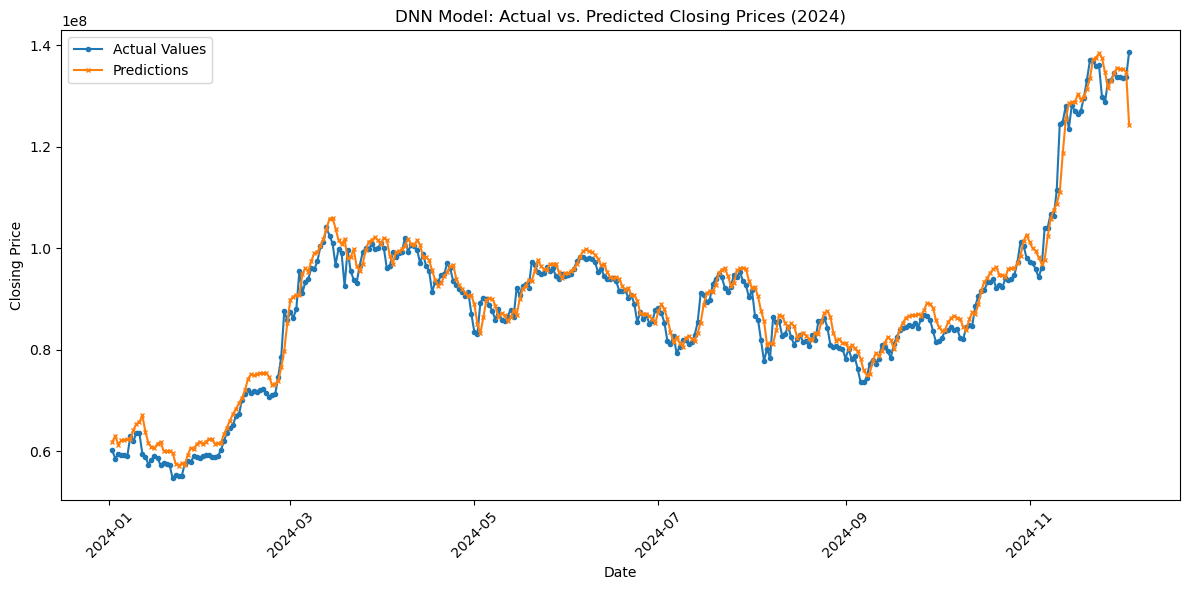

Plot saved to ./output/DNN\DNN_plot_20241230_132315.png
Predictions saved to ./output/DNN\DNN_predictions_20241230_132315.csv
Model saved to ./output/DNN\DNN_model_20241230_132315.pth


In [17]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 일별 데이터 집계
df['date'] = df['datetime'].dt.date
daily_df = df.groupby('date').agg({
    'opening_price': 'first',
    'closing_price': 'last',
    'high_price': 'max',
    'low_price': 'min',
    'trade_volume': 'sum',
    'year': 'first',
    'month': 'first',
    'day': 'first'
}).reset_index()

daily_df.sort_values(by='date', inplace=True)
daily_df.reset_index(drop=True, inplace=True)

# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5일 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5d_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10일 SMA 사용)
    df['10d_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10d_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10d_sma'] + 2 * df['10d_std']
    df['lower_band'] = df['10d_sma'] - 2 * df['10d_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10d_sma']

    # RSI 계산 (9일)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5일)
    df['low_5d'] = df['low_price'].rolling(window=5).min()
    df['high_5d'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5d']) / (df['high_5d'] - df['low_5d'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
daily_df = calculate_technical_indicators(daily_df)

# 데이터 분할
validation_year = 2024
train_test_df = daily_df[daily_df['year'] < validation_year]
validation_df = daily_df[daily_df['year'] == validation_year]

train_ratio = 0.7
train_size = int(len(train_test_df) * train_ratio)
train_df = train_test_df[:train_size]
test_df = train_test_df[train_size:]

# 데이터 분할 확인
print(f"train_df length: {len(train_df)}")
print(f"test_df length: {len(test_df)}")
print(f"validation_df length: {len(validation_df)}")

# 입력 피처 선택 (논문 기반)
features = [
    'opening_price',  'high_price', 'low_price', '5d_wma', 
    '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d', 'year', 'month', 'day'
]
target = 'next_day_closing_price'  # 다음 날 종가 예측을 위해 변경

# 데이터 스케일링
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
validation_df[features] = scaler.transform(validation_df[features])

# 타겟 변수 생성 (다음 날 종가)
train_df['next_day_closing_price'] = train_df['closing_price'].shift(-1)
test_df['next_day_closing_price'] = test_df['closing_price'].shift(-1)


train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
       return len(self.target) - self.sequence_length if len(self.target) > self.sequence_length else 0
    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length -1] # sequence_length 가 1이므로 idx + 0을 참조
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

sequence_length = 1
train_dataset = BitcoinDataset(train_df, features, 'next_day_closing_price', sequence_length)
test_dataset = BitcoinDataset(test_df, features, 'next_day_closing_price', sequence_length)
validation_dataset = BitcoinDataset(validation_df, features, 'closing_price', sequence_length)

# 데이터 로더 생성
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
         h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         return out
    
# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
hidden_size = 100  # 논문 기반으로 적절한 값 설정
num_layers = 5  # DNN 레이어 수 (논문 기반)
model_type = 'DNN' # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')

if model_type == 'DNN':
  model = DNN(input_size, hidden_size, num_layers).to(device)
elif model_type == 'BasicRNN':
  model = BasicRNN(input_size, hidden_size).to(device)
elif model_type == 'LSTM-RNN':
  model = LSTM_RNN(input_size, hidden_size).to(device)
elif model_type == 'GRU-RNN':
  model = GRU_RNN(input_size, hidden_size).to(device)
elif model_type == 'BidirectionalRNN':
    model = BidirectionalRNN(input_size, hidden_size).to(device)
else:
  raise ValueError("Invalid Model type")
  

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100 # 논문 기반 에폭 수

def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

def validate_model(model, validation_loader, model_type, validation_df):
    model.eval()
    predictions = []
    actual_values = []
    with torch.no_grad():
        for seq_x, seq_y in validation_loader:
            seq_x = seq_x.to(device)
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
    actual_values = validation_df['closing_price'].values[1:]
    return predictions, actual_values

def plot_predictions(actual_values, predictions, validation_df, model_type):
    # 시각화
    dates = validation_df['date'].values[1:]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_values, label='Actual Values', marker='o', linestyle='-', markersize=3)
    plt.plot(dates, predictions, label='Predictions', marker='x', linestyle='-', markersize=3)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'{model_type} Model: Actual vs. Predicted Closing Prices (2024)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # 이미지 저장 경로 설정
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_plot_{timestamp}.png')

    plt.savefig(output_path)
    plt.show()
    print(f"Plot saved to {output_path}")
    
def save_predictions_to_csv(actual_values, predictions, validation_df, model_type):
    dates = validation_df['date'].values[1:]
    df = pd.DataFrame({'Date': dates, 'Actual Closing Price': actual_values, 'Predicted Closing Price': predictions})
    
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_predictions_{timestamp}.csv')
    
    df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")

if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type)
    # 모델 평가
    evaluate_model(trained_model, test_loader, criterion, model_type)
    # 모델 검증
    predictions, actual_values = validate_model(trained_model, validation_loader, model_type, validation_df)
    # 예측 시각화
    plot_predictions(actual_values, predictions, validation_df, model_type)
    
    # 예측 결과 CSV 파일 저장
    save_predictions_to_csv(actual_values, predictions, validation_df, model_type)

    # 모델 저장
    model_save_path = os.path.join(f'./output/{model_type}', f'{model_type}_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3808\1835726100.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['next_day_closing_price'] = train_df['closing_price'].shift(-1)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3808\1835726100.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['next_day_closing_price'] = test_df['closing_price'].shift(-1)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3808\1835726100.py:119: SettingWithCopyWarning: 
A value is 

Using device: cuda


c:\Users\User\anaconda3\envs\Pytorch_CK\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/500: 100%|██████████| 50/50 [00:00<00:00, 59.78it/s]


Epoch 1/500, Average Loss: 0.6924, Val Loss: 0.6923


Epoch 2/500: 100%|██████████| 50/50 [00:00<00:00, 93.80it/s]


Epoch 2/500, Average Loss: 0.6911, Val Loss: 0.6922


Epoch 3/500: 100%|██████████| 50/50 [00:00<00:00, 90.21it/s]


Epoch 3/500, Average Loss: 0.6904, Val Loss: 0.6918


Epoch 4/500: 100%|██████████| 50/50 [00:00<00:00, 98.45it/s] 


Epoch 4/500, Average Loss: 0.6915, Val Loss: 0.6917


Epoch 5/500: 100%|██████████| 50/50 [00:00<00:00, 96.88it/s]


Epoch 5/500, Average Loss: 0.6909, Val Loss: 0.6920


Epoch 6/500: 100%|██████████| 50/50 [00:00<00:00, 92.12it/s]


Epoch 6/500, Average Loss: 0.6911, Val Loss: 0.6920


Epoch 7/500: 100%|██████████| 50/50 [00:00<00:00, 88.80it/s]


Epoch 7/500, Average Loss: 0.6911, Val Loss: 0.6919


Epoch 8/500: 100%|██████████| 50/50 [00:00<00:00, 84.62it/s]


Epoch 8/500, Average Loss: 0.6903, Val Loss: 0.6921


Epoch 9/500: 100%|██████████| 50/50 [00:00<00:00, 85.58it/s]


Epoch 9/500, Average Loss: 0.6917, Val Loss: 0.6926


Epoch 10/500: 100%|██████████| 50/50 [00:00<00:00, 94.00it/s]


Epoch 10/500, Average Loss: 0.6900, Val Loss: 0.6928


Epoch 11/500: 100%|██████████| 50/50 [00:00<00:00, 90.72it/s]


Epoch 11/500, Average Loss: 0.6891, Val Loss: 0.6944


Epoch 12/500: 100%|██████████| 50/50 [00:00<00:00, 99.48it/s] 


Epoch 12/500, Average Loss: 0.6896, Val Loss: 0.6971


Epoch 13/500: 100%|██████████| 50/50 [00:00<00:00, 94.06it/s]


Epoch 13/500, Average Loss: 0.6909, Val Loss: 0.6957


Epoch 14/500: 100%|██████████| 50/50 [00:00<00:00, 88.98it/s]


Epoch 14/500, Average Loss: 0.6889, Val Loss: 0.6957
Early stopping at epoch 14
Test Loss: 0.6963, Test Accuracy: 0.4891


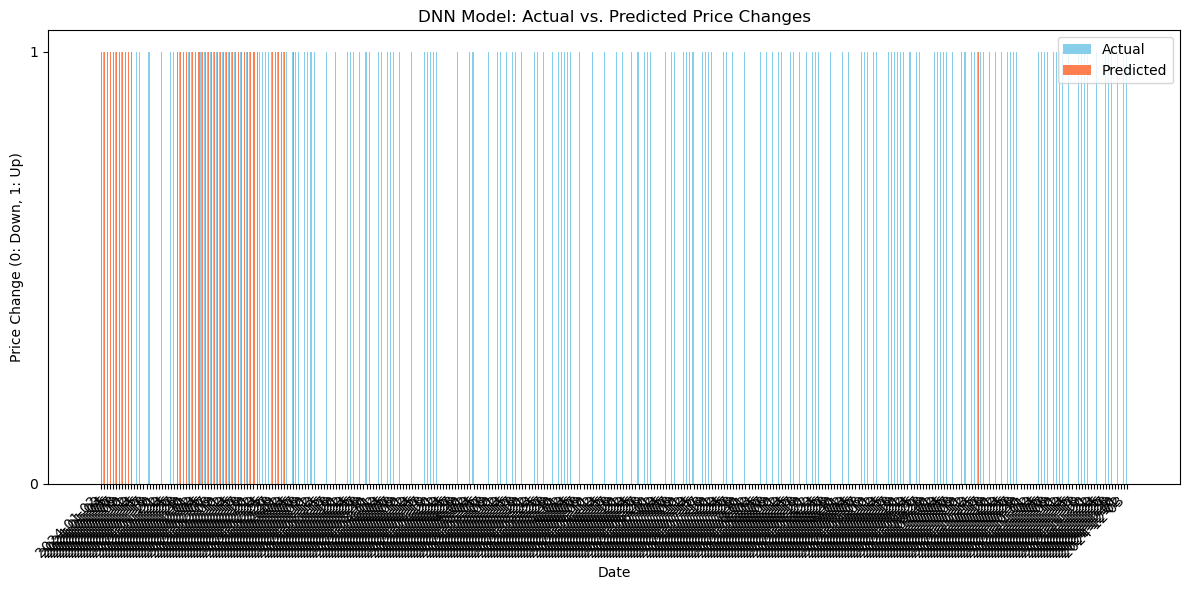

Plot saved to ./output/DNN\DNN_plot_20241230_164236.png
Predictions saved to ./output/DNN\DNN_predictions_20241230_164237.csv
Model saved to ./output/DNN\DNN_model_20241230_164237.pth


In [1]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 일별 데이터 집계
df['date'] = df['datetime'].dt.date
daily_df = df.groupby('date').agg({
    'opening_price': 'first',
    'closing_price': 'last',
    'high_price': 'max',
    'low_price': 'min',
    'trade_volume': 'sum',
    'year': 'first',
    'month': 'first',
    'day': 'first'
}).reset_index()

daily_df.sort_values(by='date', inplace=True)
daily_df.reset_index(drop=True, inplace=True)

# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5일 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5d_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10일 SMA 사용)
    df['10d_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10d_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10d_sma'] + 2 * df['10d_std']
    df['lower_band'] = df['10d_sma'] - 2 * df['10d_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10d_sma']

    # RSI 계산 (9일)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5일)
    df['low_5d'] = df['low_price'].rolling(window=5).min()
    df['high_5d'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5d']) / (df['high_5d'] - df['low_5d'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
daily_df = calculate_technical_indicators(daily_df)

# 데이터 분할
validation_year = 2024
train_test_df = daily_df[daily_df['year'] < validation_year]
validation_df = daily_df[daily_df['year'] == validation_year]

train_ratio = 0.7
train_size = int(len(train_test_df) * train_ratio)
train_df = train_test_df[:train_size]
test_df = train_test_df[train_size:]

# 입력 피처 선택 (논문 기반, sns_keyword 제외)
features = [
    'opening_price', 'closing_price', 'high_price', 'low_price', '5d_wma',
    '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d'
]

# 타겟 변수 생성 (다음 날 가격 변동: 0 or 1)
train_df['next_day_closing_price'] = train_df['closing_price'].shift(-1)
test_df['next_day_closing_price'] = test_df['closing_price'].shift(-1)
validation_df['next_day_closing_price'] = validation_df['closing_price'].shift(-1)

train_df['price_change'] = (train_df['next_day_closing_price'] > train_df['closing_price']).astype(int)
test_df['price_change'] = (test_df['next_day_closing_price'] > test_df['closing_price']).astype(int)
validation_df['price_change'] = (validation_df['next_day_closing_price'] > validation_df['closing_price']).astype(int)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
validation_df.dropna(inplace=True)

target = 'price_change'

# 스케일링
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
validation_df[features] = scaler.transform(validation_df[features])

# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
       return len(self.target) - self.sequence_length if len(self.target) > self.sequence_length else 0
    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length -1] 
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

# 모델 파라미터 설정
model_type = 'DNN'  # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')
batch_size = 32
sequence_length = 10 if model_type != 'DNN' else 1

train_dataset = BitcoinDataset(train_df, features, target, sequence_length)
test_dataset = BitcoinDataset(test_df, features, target, sequence_length)
validation_dataset = BitcoinDataset(validation_df, features, target, sequence_length)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # 드롭아웃 추가
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        layers.append(nn.Sigmoid()) # Sigmoid 추가
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, bidirectional=True, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
         h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         out = self.sigmoid(out)
         return out

# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
dropout_rate = 0.3
if model_type == 'DNN':
    hidden_size = 128
    num_layers = 4
    model = DNN(input_size, hidden_size, num_layers, dropout_rate).to(device)
elif model_type == 'BasicRNN':
    hidden_size = 64
    model = BasicRNN(input_size, hidden_size, dropout_rate).to(device)
elif model_type == 'LSTM-RNN':
    hidden_size = 64
    model = LSTM_RNN(input_size, hidden_size, dropout_rate).to(device)
elif model_type == 'GRU-RNN':
    hidden_size = 128
    model = GRU_RNN(input_size, hidden_size, dropout_rate).to(device)
elif model_type == 'BidirectionalRNN':
    hidden_size = 64
    model = BidirectionalRNN(input_size, hidden_size, dropout_rate).to(device)
else:
    raise ValueError("Invalid Model type")

# 손실 함수 및 옵티마이저
criterion = nn.BCELoss() # 이진 분류 문제이므로 BCE 손실 사용
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # 가중치 감소 추가
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 에폭 수 설정
num_epochs = 500 if model_type == 'DNN' else 400 if model_type == 'BasicRNN' else 300 if model_type in ['LSTM-RNN', 'GRU-RNN'] else 4

def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type, validation_loader, scheduler):
    model.train()
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10  # 조기 종료를 위한 patience 값 설정
    patience_counter = 0
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device).float()
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)
            
            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        # 검증 손실 계산 및 조기 종료
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for seq_x, seq_y in validation_loader:
              seq_x = seq_x.to(device)
              seq_y = seq_y.to(device).float()
              if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
              else:
                outputs = model(seq_x)
              val_loss += criterion(outputs.squeeze(), seq_y).item()
        avg_val_loss = val_loss / len(validation_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
        scheduler.step(avg_val_loss)
        model.train()
    if best_model_state is not None:
        model.load_state_dict(best_model_state)  # 최적 모델 로드
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device).float()

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)
            
            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

            # 정확도 계산
            predicted_labels = (outputs.squeeze() > 0.5).float()
            correct_predictions += (predicted_labels == seq_y).sum().item()
            total_samples += seq_y.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return accuracy

def validate_model(model, validation_loader, model_type, validation_df):
    model.eval()
    predictions = []
    actual_values = []
    dates = validation_df['date'].values[sequence_length:]
    with torch.no_grad():
        for seq_x, seq_y in validation_loader:
            seq_x = seq_x.to(device)
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
    actual_values = validation_df['price_change'].values[sequence_length:]
    predictions = [1 if p > 0.5 else 0 for p in predictions]
    return predictions, actual_values, dates

def plot_predictions(actual_values, predictions, dates, model_type):
    # 시각화
    plt.figure(figsize=(12, 6))
    
    bar_width = 0.35
    index = np.arange(len(dates))
    
    # 실제 값은 파란색 막대, 예측 값은 빨간색 막대
    plt.bar(index - bar_width/2, actual_values, bar_width, label='Actual', color='skyblue')
    plt.bar(index + bar_width/2, predictions, bar_width, label='Predicted', color='coral')

    plt.xlabel('Date')
    plt.ylabel('Price Change (0: Down, 1: Up)')
    plt.title(f'{model_type} Model: Actual vs. Predicted Price Changes')
    plt.xticks(index, dates, rotation=45, ha="right")
    plt.gca().set_yticks([0, 1])  # y축 눈금을 0과 1로 설정
    plt.legend()
    plt.tight_layout()

    # 이미지 저장 경로 설정
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_plot_{timestamp}.png')

    plt.savefig(output_path)
    plt.show()
    print(f"Plot saved to {output_path}")
    
def save_predictions_to_csv(actual_values, predictions, dates, model_type):
    df = pd.DataFrame({'Date': dates, 'Actual Price Change': actual_values, 'Predicted Price Change': predictions})
    
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_predictions_{timestamp}.csv')
    
    df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")

def predict_model(model, test_loader, model_type, test_df):
    model.eval()
    predictions = []
    actual_values = []
    dates = test_df['date'].values[sequence_length:]
    with torch.no_grad():
         for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(seq_y.cpu().numpy().flatten())
    predictions = [1 if p > 0.5 else 0 for p in predictions]
    return actual_values, predictions, dates


if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type, validation_loader, scheduler)
    # 모델 평가
    test_accuracy = evaluate_model(trained_model, test_loader, criterion, model_type)
    # 모델 예측 및 시각화
    predictions, actual_values, dates = validate_model(trained_model, validation_loader, model_type, validation_df)
    plot_predictions(actual_values, predictions, dates, model_type)
    # 예측 결과 CSV 파일 저장
    save_predictions_to_csv(actual_values, predictions, dates, model_type)
    
    # 모델 저장
    model_save_path = os.path.join(f'./output/{model_type}', f'{model_type}_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

시간봉

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3808\1872066707.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features] = scaler.fit_transform(train_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3808\1872066707.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[features] = scaler.transform(test_df[features])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3808\1872066707.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy

train_df length: 38360
test_df length: 16440
validation_df length: 8160
Using device: cuda


Epoch 1/100: 100%|██████████| 3836/3836 [00:38<00:00, 99.74it/s] 


Epoch 1/100, Average Loss: 7339956288945.5186


Epoch 2/100: 100%|██████████| 3836/3836 [00:38<00:00, 98.62it/s] 


Epoch 2/100, Average Loss: 4015181753136.6509


Epoch 3/100: 100%|██████████| 3836/3836 [00:39<00:00, 97.23it/s] 


Epoch 3/100, Average Loss: 2186757050463.4829


Epoch 4/100: 100%|██████████| 3836/3836 [00:39<00:00, 97.97it/s] 


Epoch 4/100, Average Loss: 1219104292043.7290


Epoch 5/100: 100%|██████████| 3836/3836 [00:37<00:00, 101.27it/s]


Epoch 5/100, Average Loss: 706656892188.2461


Epoch 6/100: 100%|██████████| 3836/3836 [00:35<00:00, 107.74it/s]


Epoch 6/100, Average Loss: 470932571708.5047


Epoch 7/100: 100%|██████████| 3836/3836 [00:34<00:00, 111.28it/s]


Epoch 7/100, Average Loss: 348085087027.3201


Epoch 8/100: 100%|██████████| 3836/3836 [00:35<00:00, 108.26it/s]


Epoch 8/100, Average Loss: 259558520347.7289


Epoch 9/100: 100%|██████████| 3836/3836 [00:34<00:00, 110.42it/s]


Epoch 9/100, Average Loss: 198402623189.3889


Epoch 10/100: 100%|██████████| 3836/3836 [00:36<00:00, 105.21it/s]


Epoch 10/100, Average Loss: 159931495063.2993


Epoch 11/100: 100%|██████████| 3836/3836 [00:36<00:00, 106.07it/s]


Epoch 11/100, Average Loss: 133067213488.5381


Epoch 12/100: 100%|██████████| 3836/3836 [00:35<00:00, 106.59it/s]


Epoch 12/100, Average Loss: 115241276859.3618


Epoch 13/100: 100%|██████████| 3836/3836 [00:35<00:00, 108.50it/s]


Epoch 13/100, Average Loss: 106408754105.7935


Epoch 14/100: 100%|██████████| 3836/3836 [00:36<00:00, 104.94it/s]


Epoch 14/100, Average Loss: 102184777118.0772


Epoch 15/100: 100%|██████████| 3836/3836 [00:34<00:00, 111.21it/s]


Epoch 15/100, Average Loss: 100487763246.8446


Epoch 16/100: 100%|██████████| 3836/3836 [00:35<00:00, 107.64it/s]


Epoch 16/100, Average Loss: 99672915586.4359


Epoch 17/100: 100%|██████████| 3836/3836 [00:34<00:00, 110.64it/s]


Epoch 17/100, Average Loss: 98943955617.6434


Epoch 18/100: 100%|██████████| 3836/3836 [00:35<00:00, 108.96it/s]


Epoch 18/100, Average Loss: 98619407775.8790


Epoch 19/100: 100%|██████████| 3836/3836 [00:34<00:00, 111.97it/s]


Epoch 19/100, Average Loss: 98872830041.0219


Epoch 20/100: 100%|██████████| 3836/3836 [00:32<00:00, 117.86it/s]


Epoch 20/100, Average Loss: 98447025117.3097


Epoch 21/100: 100%|██████████| 3836/3836 [00:34<00:00, 112.18it/s]


Epoch 21/100, Average Loss: 98292934863.2847


Epoch 22/100: 100%|██████████| 3836/3836 [00:35<00:00, 109.23it/s]


Epoch 22/100, Average Loss: 98075983647.1408


Epoch 23/100: 100%|██████████| 3836/3836 [00:34<00:00, 111.04it/s]


Epoch 23/100, Average Loss: 98001103873.8540


Epoch 24/100: 100%|██████████| 3836/3836 [00:34<00:00, 110.15it/s]


Epoch 24/100, Average Loss: 97754073282.5151


Epoch 25/100: 100%|██████████| 3836/3836 [00:34<00:00, 110.51it/s]


Epoch 25/100, Average Loss: 97272806888.9781


Epoch 26/100: 100%|██████████| 3836/3836 [00:33<00:00, 114.93it/s]


Epoch 26/100, Average Loss: 97374661845.3764


Epoch 27/100: 100%|██████████| 3836/3836 [00:33<00:00, 114.59it/s]


Epoch 27/100, Average Loss: 97458375105.1929


Epoch 28/100: 100%|██████████| 3836/3836 [00:33<00:00, 113.24it/s]


Epoch 28/100, Average Loss: 97505852735.9604


Epoch 29/100: 100%|██████████| 3836/3836 [00:33<00:00, 114.90it/s]


Epoch 29/100, Average Loss: 97439467869.9562


Epoch 30/100: 100%|██████████| 3836/3836 [00:33<00:00, 113.26it/s]


Epoch 30/100, Average Loss: 97356125525.7497


Epoch 31/100: 100%|██████████| 3836/3836 [00:34<00:00, 111.97it/s]


Epoch 31/100, Average Loss: 97013913514.5005


Epoch 32/100: 100%|██████████| 3836/3836 [00:35<00:00, 109.56it/s]


Epoch 32/100, Average Loss: 97291002380.4359


Epoch 33/100: 100%|██████████| 3836/3836 [00:34<00:00, 111.09it/s]


Epoch 33/100, Average Loss: 97468490669.0970


Epoch 34/100: 100%|██████████| 3836/3836 [00:34<00:00, 111.09it/s]


Epoch 34/100, Average Loss: 96823262952.3170


Epoch 35/100: 100%|██████████| 3836/3836 [00:33<00:00, 114.21it/s]


Epoch 35/100, Average Loss: 96117359369.3201


Epoch 36/100: 100%|██████████| 3836/3836 [00:34<00:00, 110.23it/s]


Epoch 36/100, Average Loss: 95799623600.3618


Epoch 37/100: 100%|██████████| 3836/3836 [00:34<00:00, 110.41it/s]


Epoch 37/100, Average Loss: 96988903381.6340


Epoch 38/100: 100%|██████████| 3836/3836 [00:19<00:00, 200.78it/s]


Epoch 38/100, Average Loss: 96319038445.4911


Epoch 39/100: 100%|██████████| 3836/3836 [00:05<00:00, 668.47it/s]


Epoch 39/100, Average Loss: 96281233420.4943


Epoch 40/100: 100%|██████████| 3836/3836 [00:06<00:00, 627.17it/s]


Epoch 40/100, Average Loss: 96008405197.6079


Epoch 41/100: 100%|██████████| 3836/3836 [00:06<00:00, 621.69it/s]


Epoch 41/100, Average Loss: 95870416363.5516


Epoch 42/100: 100%|██████████| 3836/3836 [00:06<00:00, 633.06it/s]


Epoch 42/100, Average Loss: 95954324425.5182


Epoch 43/100: 100%|██████████| 3836/3836 [00:06<00:00, 634.94it/s]


Epoch 43/100, Average Loss: 95247292565.1199


Epoch 44/100: 100%|██████████| 3836/3836 [00:06<00:00, 638.58it/s]


Epoch 44/100, Average Loss: 95466788401.3681


Epoch 45/100: 100%|██████████| 3836/3836 [00:06<00:00, 623.12it/s]


Epoch 45/100, Average Loss: 95375326172.6423


Epoch 46/100: 100%|██████████| 3836/3836 [00:05<00:00, 661.33it/s]


Epoch 46/100, Average Loss: 95163251181.9520


Epoch 47/100: 100%|██████████| 3836/3836 [00:05<00:00, 741.31it/s]


Epoch 47/100, Average Loss: 94842103207.3702


Epoch 48/100: 100%|██████████| 3836/3836 [00:05<00:00, 639.43it/s]


Epoch 48/100, Average Loss: 94776744048.9635


Epoch 49/100: 100%|██████████| 3836/3836 [00:06<00:00, 628.04it/s]


Epoch 49/100, Average Loss: 94518379733.3431


Epoch 50/100: 100%|██████████| 3836/3836 [00:06<00:00, 630.74it/s]


Epoch 50/100, Average Loss: 94097980238.1689


Epoch 51/100: 100%|██████████| 3836/3836 [00:06<00:00, 629.55it/s]


Epoch 51/100, Average Loss: 94129605041.6392


Epoch 52/100: 100%|██████████| 3836/3836 [00:06<00:00, 629.69it/s]


Epoch 52/100, Average Loss: 93954887781.6350


Epoch 53/100: 100%|██████████| 3836/3836 [00:06<00:00, 635.57it/s]


Epoch 53/100, Average Loss: 93762002829.9562


Epoch 54/100: 100%|██████████| 3836/3836 [00:06<00:00, 628.77it/s]


Epoch 54/100, Average Loss: 93482984550.3608


Epoch 55/100: 100%|██████████| 3836/3836 [00:06<00:00, 638.56it/s]


Epoch 55/100, Average Loss: 93452531884.9426


Epoch 56/100: 100%|██████████| 3836/3836 [00:06<00:00, 631.06it/s]


Epoch 56/100, Average Loss: 93313742254.9468


Epoch 57/100: 100%|██████████| 3836/3836 [00:06<00:00, 638.46it/s]


Epoch 57/100, Average Loss: 93064765538.8238


Epoch 58/100: 100%|██████████| 3836/3836 [00:06<00:00, 629.49it/s]


Epoch 58/100, Average Loss: 92939226835.5537


Epoch 59/100: 100%|██████████| 3836/3836 [00:06<00:00, 638.93it/s]


Epoch 59/100, Average Loss: 92446448699.8916


Epoch 60/100: 100%|██████████| 3836/3836 [00:06<00:00, 629.62it/s]


Epoch 60/100, Average Loss: 92190797800.3921


Epoch 61/100: 100%|██████████| 3836/3836 [00:06<00:00, 630.78it/s]


Epoch 61/100, Average Loss: 92107060602.1335


Epoch 62/100: 100%|██████████| 3836/3836 [00:06<00:00, 627.73it/s]


Epoch 62/100, Average Loss: 91886202625.6611


Epoch 63/100: 100%|██████████| 3836/3836 [00:06<00:00, 636.66it/s]


Epoch 63/100, Average Loss: 91693473474.7758


Epoch 64/100: 100%|██████████| 3836/3836 [00:06<00:00, 639.10it/s]


Epoch 64/100, Average Loss: 91608397438.6715


Epoch 65/100: 100%|██████████| 3836/3836 [00:06<00:00, 622.44it/s]


Epoch 65/100, Average Loss: 91447788025.3483


Epoch 66/100: 100%|██████████| 3836/3836 [00:05<00:00, 648.87it/s]


Epoch 66/100, Average Loss: 91273059530.1585


Epoch 67/100: 100%|██████████| 3836/3836 [00:05<00:00, 730.95it/s]


Epoch 67/100, Average Loss: 91356542518.2221


Epoch 68/100: 100%|██████████| 3836/3836 [00:05<00:00, 688.73it/s]


Epoch 68/100, Average Loss: 90599121798.6642


Epoch 69/100: 100%|██████████| 3836/3836 [00:05<00:00, 757.41it/s]


Epoch 69/100, Average Loss: 90313476095.1825


Epoch 70/100: 100%|██████████| 3836/3836 [00:05<00:00, 698.39it/s]


Epoch 70/100, Average Loss: 90205643629.8697


Epoch 71/100: 100%|██████████| 3836/3836 [00:05<00:00, 683.93it/s]


Epoch 71/100, Average Loss: 90006756480.4661


Epoch 72/100: 100%|██████████| 3836/3836 [00:05<00:00, 696.05it/s]


Epoch 72/100, Average Loss: 89872759449.4056


Epoch 73/100: 100%|██████████| 3836/3836 [00:05<00:00, 696.91it/s]


Epoch 73/100, Average Loss: 89802826360.1220


Epoch 74/100: 100%|██████████| 3836/3836 [00:05<00:00, 707.55it/s]


Epoch 74/100, Average Loss: 89750619586.0938


Epoch 75/100: 100%|██████████| 3836/3836 [00:05<00:00, 692.93it/s]


Epoch 75/100, Average Loss: 89724650949.4327


Epoch 76/100: 100%|██████████| 3836/3836 [00:05<00:00, 688.67it/s]


Epoch 76/100, Average Loss: 89565092797.7268


Epoch 77/100: 100%|██████████| 3836/3836 [00:05<00:00, 693.44it/s]


Epoch 77/100, Average Loss: 89798447662.9604


Epoch 78/100: 100%|██████████| 3836/3836 [00:05<00:00, 697.53it/s]


Epoch 78/100, Average Loss: 89734559743.3608


Epoch 79/100: 100%|██████████| 3836/3836 [00:05<00:00, 703.00it/s]


Epoch 79/100, Average Loss: 89525921001.9541


Epoch 80/100: 100%|██████████| 3836/3836 [00:05<00:00, 695.35it/s]


Epoch 80/100, Average Loss: 89343633082.9207


Epoch 81/100: 100%|██████████| 3836/3836 [00:05<00:00, 687.12it/s]


Epoch 81/100, Average Loss: 89379482711.5255


Epoch 82/100: 100%|██████████| 3836/3836 [00:05<00:00, 687.58it/s]


Epoch 82/100, Average Loss: 89488860781.4870


Epoch 83/100: 100%|██████████| 3836/3836 [00:05<00:00, 699.49it/s]


Epoch 83/100, Average Loss: 89427385900.9969


Epoch 84/100: 100%|██████████| 3836/3836 [00:05<00:00, 708.10it/s]


Epoch 84/100, Average Loss: 89344349884.4119


Epoch 85/100: 100%|██████████| 3836/3836 [00:05<00:00, 701.77it/s]


Epoch 85/100, Average Loss: 89388935582.8060


Epoch 86/100: 100%|██████████| 3836/3836 [00:05<00:00, 685.32it/s]


Epoch 86/100, Average Loss: 89293000927.5026


Epoch 87/100: 100%|██████████| 3836/3836 [00:05<00:00, 681.56it/s]


Epoch 87/100, Average Loss: 89276735905.2753


Epoch 88/100: 100%|██████████| 3836/3836 [00:05<00:00, 650.19it/s]


Epoch 88/100, Average Loss: 89189547521.4734


Epoch 89/100: 100%|██████████| 3836/3836 [00:05<00:00, 686.24it/s]


Epoch 89/100, Average Loss: 89349125002.6350


Epoch 90/100: 100%|██████████| 3836/3836 [00:05<00:00, 713.10it/s]


Epoch 90/100, Average Loss: 89524335387.3483


Epoch 91/100: 100%|██████████| 3836/3836 [00:05<00:00, 690.32it/s]


Epoch 91/100, Average Loss: 89638461064.2169


Epoch 92/100: 100%|██████████| 3836/3836 [00:05<00:00, 677.17it/s]


Epoch 92/100, Average Loss: 89781942462.6225


Epoch 93/100: 100%|██████████| 3836/3836 [00:05<00:00, 683.03it/s]


Epoch 93/100, Average Loss: 89964960432.7852


Epoch 94/100: 100%|██████████| 3836/3836 [00:05<00:00, 695.90it/s]


Epoch 94/100, Average Loss: 90049532826.9124


Epoch 95/100: 100%|██████████| 3836/3836 [00:05<00:00, 699.69it/s]


Epoch 95/100, Average Loss: 90111759075.8676


Epoch 96/100: 100%|██████████| 3836/3836 [00:05<00:00, 689.41it/s]


Epoch 96/100, Average Loss: 90212003501.6548


Epoch 97/100: 100%|██████████| 3836/3836 [00:05<00:00, 693.03it/s]


Epoch 97/100, Average Loss: 90549583724.9865


Epoch 98/100: 100%|██████████| 3836/3836 [00:05<00:00, 694.52it/s]


Epoch 98/100, Average Loss: 90748935791.1303


Epoch 99/100: 100%|██████████| 3836/3836 [00:05<00:00, 695.13it/s]


Epoch 99/100, Average Loss: 91090010987.0469


Epoch 100/100: 100%|██████████| 3836/3836 [00:05<00:00, 699.38it/s]


Epoch 100/100, Average Loss: 91367551124.6674
Test Loss: 25048236698539.2891


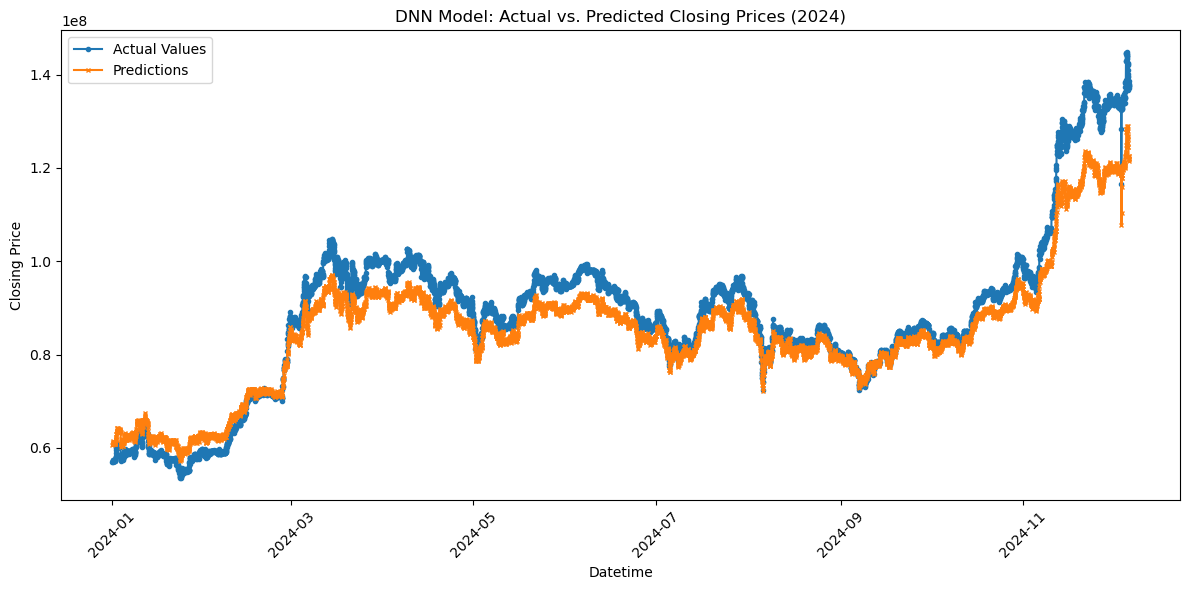

Plot saved to ./output/DNN\DNN_plot_20241230_174532.png
Predictions saved to ./output/DNN\DNN_predictions_20241230_174533.csv
Model saved to ./output/DNN\DNN_model_20241230_174533.pth


In [2]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os

# 데이터베이스 파일 경로
db_file = '../btc_data_hour1_20170901_20241206.db' # 시간봉 데이터베이스 파일 경로 변경

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df.reset_index(drop=True, inplace=True)

# 시간별 데이터 집계 (분봉이 아닌 시간봉 데이터이므로 groupby는 불필요)
hourly_df = df.copy() # 분봉에서 시간봉이 되었으므로 바로 사용

hourly_df.sort_values(by='datetime', inplace=True)
hourly_df.reset_index(drop=True, inplace=True)


# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5시간 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5h_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10시간 SMA 사용)
    df['10h_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10h_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10h_sma'] + 2 * df['10h_std']
    df['lower_band'] = df['10h_sma'] - 2 * df['10h_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10h_sma']

    # RSI 계산 (9시간)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5시간)
    df['low_5h'] = df['low_price'].rolling(window=5).min()
    df['high_5h'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5h']) / (df['high_5h'] - df['low_5h'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
hourly_df = calculate_technical_indicators(hourly_df)

# 데이터 분할
validation_year = 2024
train_test_df = hourly_df[hourly_df['year'] < validation_year]
validation_df = hourly_df[hourly_df['year'] == validation_year]

train_ratio = 0.7
train_size = int(len(train_test_df) * train_ratio)
train_df = train_test_df[:train_size]
test_df = train_test_df[train_size:]

# 데이터 분할 확인
print(f"train_df length: {len(train_df)}")
print(f"test_df length: {len(test_df)}")
print(f"validation_df length: {len(validation_df)}")

# 입력 피처 선택 (논문 기반)
features = [
    'opening_price',  'high_price', 'low_price', '5h_wma', 
    '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d', 'year', 'month', 'day', 'hour'
]
target = 'next_hour_closing_price'  # 다음 시간 종가 예측을 위해 변경

# 데이터 스케일링
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
validation_df[features] = scaler.transform(validation_df[features])

# 타겟 변수 생성 (다음 시간 종가)
train_df['next_hour_closing_price'] = train_df['closing_price'].shift(-1)
test_df['next_hour_closing_price'] = test_df['closing_price'].shift(-1)


train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
       return len(self.target) - self.sequence_length if len(self.target) > self.sequence_length else 0
    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length -1] # sequence_length 가 1이므로 idx + 0을 참조
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

sequence_length = 1
train_dataset = BitcoinDataset(train_df, features, 'next_hour_closing_price', sequence_length)
test_dataset = BitcoinDataset(test_df, features, 'next_hour_closing_price', sequence_length)
validation_dataset = BitcoinDataset(validation_df, features, 'closing_price', sequence_length)

# 데이터 로더 생성
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
         h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         return out
    
# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
hidden_size = 100  # 논문 기반으로 적절한 값 설정
num_layers = 5  # DNN 레이어 수 (논문 기반)
model_type = 'DNN' # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')

if model_type == 'DNN':
  model = DNN(input_size, hidden_size, num_layers).to(device)
elif model_type == 'BasicRNN':
  model = BasicRNN(input_size, hidden_size).to(device)
elif model_type == 'LSTM-RNN':
  model = LSTM_RNN(input_size, hidden_size).to(device)
elif model_type == 'GRU-RNN':
  model = GRU_RNN(input_size, hidden_size).to(device)
elif model_type == 'BidirectionalRNN':
    model = BidirectionalRNN(input_size, hidden_size).to(device)
else:
  raise ValueError("Invalid Model type")
  

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100 # 논문 기반 에폭 수

def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)

            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")

def validate_model(model, validation_loader, model_type, validation_df):
    model.eval()
    predictions = []
    actual_values = []
    with torch.no_grad():
        for seq_x, seq_y in validation_loader:
            seq_x = seq_x.to(device)
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
    actual_values = validation_df['closing_price'].values[1:]
    return predictions, actual_values

def plot_predictions(actual_values, predictions, validation_df, model_type):
    # 시각화
    dates = validation_df['datetime'].values[1:] # x축을 datetime으로 변경
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_values, label='Actual Values', marker='o', linestyle='-', markersize=3)
    plt.plot(dates, predictions, label='Predictions', marker='x', linestyle='-', markersize=3)
    plt.xlabel('Datetime')
    plt.ylabel('Closing Price')
    plt.title(f'{model_type} Model: Actual vs. Predicted Closing Prices (2024)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # 이미지 저장 경로 설정
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_plot_{timestamp}.png')

    plt.savefig(output_path)
    plt.show()
    print(f"Plot saved to {output_path}")
    
def save_predictions_to_csv(actual_values, predictions, validation_df, model_type):
    dates = validation_df['datetime'].values[1:] # datetime으로 변경
    df = pd.DataFrame({'Datetime': dates, 'Actual Closing Price': actual_values, 'Predicted Closing Price': predictions})
    
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_predictions_{timestamp}.csv')
    
    df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")

if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type)
    # 모델 평가
    evaluate_model(trained_model, test_loader, criterion, model_type)
    # 모델 검증
    predictions, actual_values = validate_model(trained_model, validation_loader, model_type, validation_df)
    # 예측 시각화
    plot_predictions(actual_values, predictions, validation_df, model_type)
    
    # 예측 결과 CSV 파일 저장
    save_predictions_to_csv(actual_values, predictions, validation_df, model_type)

    # 모델 저장
    model_save_path = os.path.join(f'./output/{model_type}', f'{model_type}_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_13664\3511470539.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['next_day_closing_price'] = train_df['closing_price'].shift(-1)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_13664\3511470539.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['next_day_closing_price'] = test_df['closing_price'].shift(-1)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_13664\3511470539.py:122: SettingWithCopyWarning: 
A value 

Using device: cuda


Epoch 1/100: 100%|██████████| 160/160 [00:00<00:00, 273.06it/s]
c:\Users\User\anaconda3\envs\Pytorch_CK\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/100, Average Loss: 0.8312, Val Loss: 0.7353


Epoch 2/100: 100%|██████████| 160/160 [00:00<00:00, 539.93it/s]


Epoch 2/100, Average Loss: 0.7696, Val Loss: 0.7195


Epoch 3/100: 100%|██████████| 160/160 [00:00<00:00, 517.86it/s]


Epoch 3/100, Average Loss: 0.7744, Val Loss: 0.7095


Epoch 4/100: 100%|██████████| 160/160 [00:00<00:00, 495.29it/s]


Epoch 4/100, Average Loss: 0.7465, Val Loss: 0.7146


Epoch 5/100: 100%|██████████| 160/160 [00:00<00:00, 545.59it/s]


Epoch 5/100, Average Loss: 0.7258, Val Loss: 0.7157


Epoch 6/100: 100%|██████████| 160/160 [00:00<00:00, 517.41it/s]


Epoch 6/100, Average Loss: 0.7115, Val Loss: 0.6962


Epoch 7/100: 100%|██████████| 160/160 [00:00<00:00, 436.43it/s]


Epoch 7/100, Average Loss: 0.7062, Val Loss: 0.7087


Epoch 8/100: 100%|██████████| 160/160 [00:00<00:00, 447.13it/s]


Epoch 8/100, Average Loss: 0.7035, Val Loss: 0.6992


Epoch 9/100: 100%|██████████| 160/160 [00:00<00:00, 490.49it/s]


Epoch 9/100, Average Loss: 0.7022, Val Loss: 0.7047


Epoch 10/100: 100%|██████████| 160/160 [00:00<00:00, 523.62it/s]


Epoch 10/100, Average Loss: 0.6879, Val Loss: 0.7053


Epoch 11/100: 100%|██████████| 160/160 [00:00<00:00, 532.21it/s]


Epoch 11/100, Average Loss: 0.6908, Val Loss: 0.7136


Epoch 12/100: 100%|██████████| 160/160 [00:00<00:00, 522.43it/s]


Epoch 12/100, Average Loss: 0.6891, Val Loss: 0.7098


Epoch 13/100: 100%|██████████| 160/160 [00:00<00:00, 521.20it/s]


Epoch 13/100, Average Loss: 0.6853, Val Loss: 0.7101


Epoch 14/100: 100%|██████████| 160/160 [00:00<00:00, 513.36it/s]


Epoch 14/100, Average Loss: 0.6922, Val Loss: 0.7069


Epoch 15/100: 100%|██████████| 160/160 [00:00<00:00, 432.99it/s]


Epoch 15/100, Average Loss: 0.6835, Val Loss: 0.7049


Epoch 16/100: 100%|██████████| 160/160 [00:00<00:00, 442.69it/s]


Epoch 16/100, Average Loss: 0.6834, Val Loss: 0.7085
Early stopping at epoch 16
Test Loss: 0.7266, Test Accuracy: 0.4993


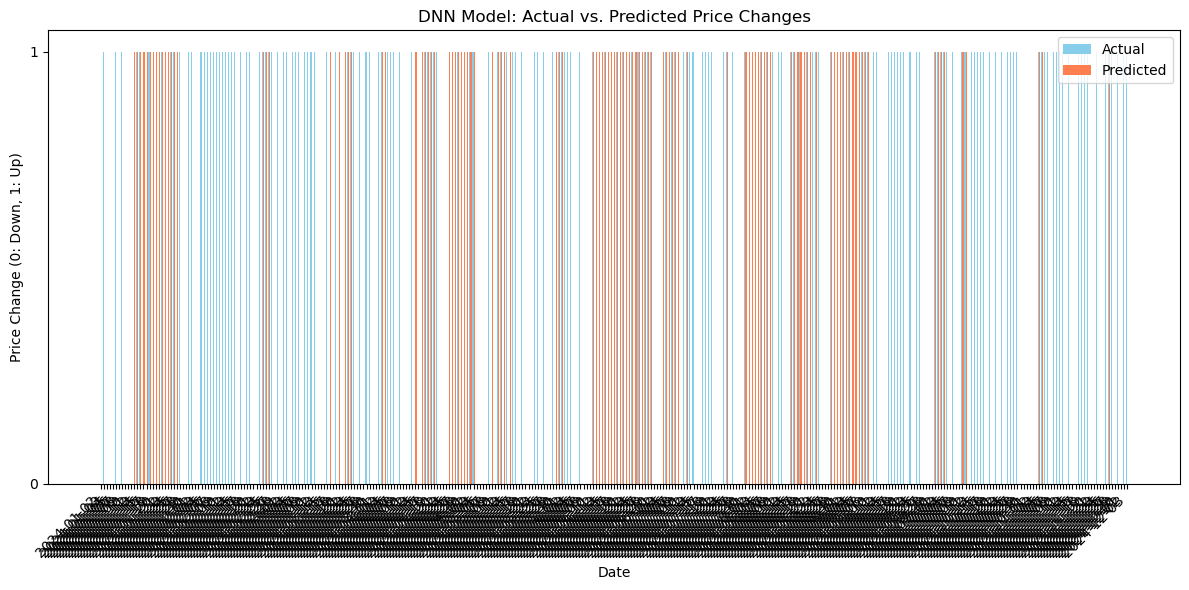

Plot saved to ./output/DNN\DNN_plot_20241231_105544.png
Predictions saved to ./output/DNN\DNN_predictions_20241231_105545.csv
Model saved to ./output/DNN\DNN_model_20241231_105545.pth


In [3]:
import numpy as np
import pandas as pd
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.nn.init import xavier_uniform_
from torch.optim.lr_scheduler import CosineAnnealingLR

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df.reset_index(drop=True, inplace=True)

# 일별 데이터 집계
df['date'] = df['datetime'].dt.date
daily_df = df.groupby('date').agg({
    'opening_price': 'first',
    'closing_price': 'last',
    'high_price': 'max',
    'low_price': 'min',
    'trade_volume': 'sum',
    'year': 'first',
    'month': 'first',
    'day': 'first'
}).reset_index()

daily_df.sort_values(by='date', inplace=True)
daily_df.reset_index(drop=True, inplace=True)

# 기술 지표 계산 함수
def calculate_technical_indicators(df, window=10):
    # 5일 WMA 계산
    weights = np.arange(1, 6)
    weights = weights / weights.sum()
    df['5d_wma'] = df['closing_price'].rolling(window=5).apply(lambda prices: np.dot(prices, weights))

    # 볼린저 밴드 계산 (10일 SMA 사용)
    df['10d_sma'] = df['closing_price'].rolling(window=window).mean()
    df['10d_std'] = df['closing_price'].rolling(window=window).std()
    df['upper_band'] = df['10d_sma'] + 2 * df['10d_std']
    df['lower_band'] = df['10d_sma'] - 2 * df['10d_std']
    df['%b'] = (df['closing_price'] - df['lower_band']) / (df['upper_band'] - df['lower_band'])
    df['bandwidth'] = (df['upper_band'] - df['lower_band']) / df['10d_sma']

    # RSI 계산 (9일)
    delta = df['closing_price'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=9).mean()
    avg_loss = loss.rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD 계산
    ema_12 = df['closing_price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['closing_price'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator 계산 (5일)
    df['low_5d'] = df['low_price'].rolling(window=5).min()
    df['high_5d'] = df['high_price'].rolling(window=5).max()
    df['%k'] = (df['closing_price'] - df['low_5d']) / (df['high_5d'] - df['low_5d'])
    df['%d'] = df['%k'].rolling(window=3).mean()
    
    df.fillna(0, inplace=True)
    return df

# 기술 지표 계산
daily_df = calculate_technical_indicators(daily_df)

# 데이터 분할
validation_year = 2024
train_test_df = daily_df[daily_df['year'] < validation_year]
validation_df = daily_df[daily_df['year'] == validation_year]

train_ratio = 0.7
train_size = int(len(train_test_df) * train_ratio)
train_df = train_test_df[:train_size]
test_df = train_test_df[train_size:]

# 입력 피처 선택 (논문 기반, 감성 지표 제외)
features = [
    'opening_price', 'high_price', 'low_price', '5d_wma',
    '%b', 'bandwidth', 'rsi', 'macd', 'macd_signal', '%k', '%d'
]

# 타겟 변수 생성 (다음 날 가격 변동: 0 or 1)
train_df['next_day_closing_price'] = train_df['closing_price'].shift(-1)
test_df['next_day_closing_price'] = test_df['closing_price'].shift(-1)
validation_df['next_day_closing_price'] = validation_df['closing_price'].shift(-1)

train_df['price_change'] = (train_df['next_day_closing_price'] > train_df['closing_price']).astype(int)
test_df['price_change'] = (test_df['next_day_closing_price'] > test_df['closing_price']).astype(int)
validation_df['price_change'] = (validation_df['next_day_closing_price'] > validation_df['closing_price']).astype(int)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
validation_df.dropna(inplace=True)

target = 'price_change'

# 스케일링
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])
validation_df[features] = scaler.transform(validation_df[features])


# 데이터셋 생성
class BitcoinDataset(Dataset):
    def __init__(self, df, features, target, sequence_length=1):
        self.features = df[features].values
        self.target = df[target].values
        self.sequence_length = sequence_length
        
    def __len__(self):
       return len(self.target) - self.sequence_length if len(self.target) > self.sequence_length else 0
    def __getitem__(self, idx):
        seq_x = self.features[idx:idx + self.sequence_length]
        seq_y = self.target[idx + self.sequence_length -1] 
        
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

# 모델 파라미터 설정
model_type = 'DNN'  # 모델 종류 선택 ('DNN', 'BasicRNN', 'LSTM-RNN', 'GRU-RNN', 'BidirectionalRNN')
batch_size = 10
sequence_length = 10 if model_type != 'DNN' else 1

train_dataset = BitcoinDataset(train_df, features, target, sequence_length)
test_dataset = BitcoinDataset(test_df, features, target, sequence_length)
validation_dataset = BitcoinDataset(validation_df, features, target, sequence_length)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# DNN 모델
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(DNN, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.BatchNorm1d(hidden_size))
        layers.append(nn.Linear(hidden_size, 1))  # 출력 레이어
        layers.append(nn.Sigmoid()) # Sigmoid 추가
        self.layers = nn.Sequential(*layers)
        for m in self.modules():
           if isinstance(m, nn.Linear):
                xavier_uniform_(m.weight)

    def forward(self, x):
        return self.layers(x)

# 기본 RNN 모델
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers = num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        for m in self.modules():
           if isinstance(m, nn.RNN):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                       xavier_uniform_(param)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out
    
# LSTM-RNN 모델
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        for m in self.modules():
           if isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                       xavier_uniform_(param)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out
    
# GRU-RNN 모델
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(GRU_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        for m in self.modules():
           if isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                       xavier_uniform_(param)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

# 양방향 RNN 모델
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.3):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()
        for m in self.modules():
           if isinstance(m, nn.RNN):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                       xavier_uniform_(param)
    def forward(self, x):
         h0 = torch.zeros(num_layers * 2, x.size(0), self.hidden_size).to(device)
         out, _ = self.rnn(x, h0)
         out = self.fc(out[:, -1, :])
         out = self.sigmoid(out)
         return out

# 모델 선택 (원하는 모델로 변경)
input_size = len(features)
dropout_rate = 0.3
num_layers = 2
if model_type == 'DNN':
    hidden_size = 128
    num_layers = 4
    model = DNN(input_size, hidden_size, num_layers, dropout_rate).to(device)
elif model_type == 'BasicRNN':
    hidden_size = 64
    model = BasicRNN(input_size, hidden_size, num_layers, dropout_rate).to(device)
elif model_type == 'LSTM-RNN':
    hidden_size = 64
    model = LSTM_RNN(input_size, hidden_size, num_layers, dropout_rate).to(device)
elif model_type == 'GRU-RNN':
    hidden_size = 128
    model = GRU_RNN(input_size, hidden_size, num_layers, dropout_rate).to(device)
elif model_type == 'BidirectionalRNN':
    hidden_size = 64
    model = BidirectionalRNN(input_size, hidden_size, num_layers, dropout_rate).to(device)
else:
    raise ValueError("Invalid Model type")

# 에폭 수 설정
num_epochs = 100 if model_type == 'DNN' else 250 if model_type == 'BasicRNN' else 200 if model_type in ['LSTM-RNN', 'GRU-RNN'] else 4

# 손실 함수 및 옵티마이저
criterion = nn.BCELoss() # 이진 분류 문제이므로 BCE 손실 사용
learning_rate = 0.001 # 논문 기반
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # 가중치 감소 추가
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)



def train_model(model, train_loader, criterion, optimizer, num_epochs, model_type, validation_loader, scheduler):
    model.train()
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10  # 조기 종료를 위한 patience 값 설정
    patience_counter = 0
    for epoch in range(num_epochs):
        total_loss = 0
        for seq_x, seq_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device).float()
            
            optimizer.zero_grad()
            
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)
            
            loss = criterion(outputs.squeeze(), seq_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        # 검증 손실 계산 및 조기 종료
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for seq_x, seq_y in validation_loader:
              seq_x = seq_x.to(device)
              seq_y = seq_y.to(device).float()
              if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
              else:
                outputs = model(seq_x)
              val_loss += criterion(outputs.squeeze(), seq_y).item()
        avg_val_loss = val_loss / len(validation_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
        scheduler.step(epoch)
        model.train()
    if best_model_state is not None:
        model.load_state_dict(best_model_state)  # 최적 모델 로드
    return model

def evaluate_model(model, test_loader, criterion, model_type):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)
            seq_y = seq_y.to(device).float()

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
              outputs = model(seq_x)
            
            loss = criterion(outputs.squeeze(), seq_y)
            total_loss += loss.item()

            # 정확도 계산
            predicted_labels = (outputs.squeeze() > 0.5).float()
            correct_predictions += (predicted_labels == seq_y).sum().item()
            total_samples += seq_y.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return accuracy

def validate_model(model, validation_loader, model_type, validation_df):
    model.eval()
    predictions = []
    actual_values = []
    dates = validation_df['date'].values[sequence_length:]
    with torch.no_grad():
        for seq_x, seq_y in validation_loader:
            seq_x = seq_x.to(device)
            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
    actual_values = validation_df['price_change'].values[sequence_length:]
    predictions = [1 if p > 0.5 else 0 for p in predictions]
    return predictions, actual_values, dates

def plot_predictions(actual_values, predictions, dates, model_type):
    # 시각화
    plt.figure(figsize=(12, 6))
    
    bar_width = 0.35
    index = np.arange(len(dates))
    
    # 실제 값은 파란색 막대, 예측 값은 빨간색 막대
    plt.bar(index - bar_width/2, actual_values, bar_width, label='Actual', color='skyblue')
    plt.bar(index + bar_width/2, predictions, bar_width, label='Predicted', color='coral')

    plt.xlabel('Date')
    plt.ylabel('Price Change (0: Down, 1: Up)')
    plt.title(f'{model_type} Model: Actual vs. Predicted Price Changes')
    plt.xticks(index, dates, rotation=45, ha="right")
    plt.gca().set_yticks([0, 1])  # y축 눈금을 0과 1로 설정
    plt.legend()
    plt.tight_layout()

    # 이미지 저장 경로 설정
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_plot_{timestamp}.png')

    plt.savefig(output_path)
    plt.show()
    print(f"Plot saved to {output_path}")
    
def save_predictions_to_csv(actual_values, predictions, dates, model_type):
    df = pd.DataFrame({'Date': dates, 'Actual Price Change': actual_values, 'Predicted Price Change': predictions})
    
    output_dir = f'./output/{model_type}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f'{model_type}_predictions_{timestamp}.csv')
    
    df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")

def predict_model(model, test_loader, model_type, test_df):
    model.eval()
    predictions = []
    actual_values = []
    dates = test_df['date'].values[sequence_length:]
    with torch.no_grad():
         for seq_x, seq_y in test_loader:
            seq_x = seq_x.to(device)

            if model_type == 'DNN':
                outputs = model(seq_x.squeeze(1))
            else:
                outputs = model(seq_x)
            predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(seq_y.cpu().numpy().flatten())
    predictions = [1 if p > 0.5 else 0 for p in predictions]
    return actual_values, predictions, dates


if __name__ == '__main__':
    # 모델 학습
    trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs, model_type, validation_loader, scheduler)
    # 모델 평가
    test_accuracy = evaluate_model(trained_model, test_loader, criterion, model_type)
    # 모델 예측 및 시각화
    predictions, actual_values, dates = validate_model(trained_model, validation_loader, model_type, validation_df)
    plot_predictions(actual_values, predictions, dates, model_type)
    # 예측 결과 CSV 파일 저장
    save_predictions_to_csv(actual_values, predictions, dates, model_type)
    
    # 모델 저장
    model_save_path = os.path.join(f'./output/{model_type}', f'{model_type}_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")